# SDSS Galaxies vs Quasars

Tasks
- Create arrays for the (u-g), (g-r), (r-i), (i-z) colors. Also create an array with the class labels where galaxy=0 and quasar=1.
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.

In [1]:
import sys
sys.path.append(r"C:\Users\ricca\Documents\Unimib-Code\AstroXtatistics\Notebooks\venv\Utilities")
import matplotlib.pyplot as plt 
import seaborn as sns
from Utilities import plot_settings
import numpy as np
import pandas as pd

In [2]:
data_path = r'C:\Users\ricca\OneDrive\Documents\Data\galaxyquasar.csv'
data = pd.read_csv(data_path)

In [3]:
ug = (data['u'] - data['g']).to_numpy()
gr = (data['g'] - data['r']).to_numpy()
ri = (data['r'] - data['i']).to_numpy()
iz = (data['i'] - data['z']).to_numpy()

true_labels = np.where(data['class'].to_numpy() == 'QSO', 1, 0)

In [4]:
X = np.vstack([ug, gr, ri, iz]).T
y = true_labels

Data exploration

In [5]:
from matplotlib.lines import Line2D

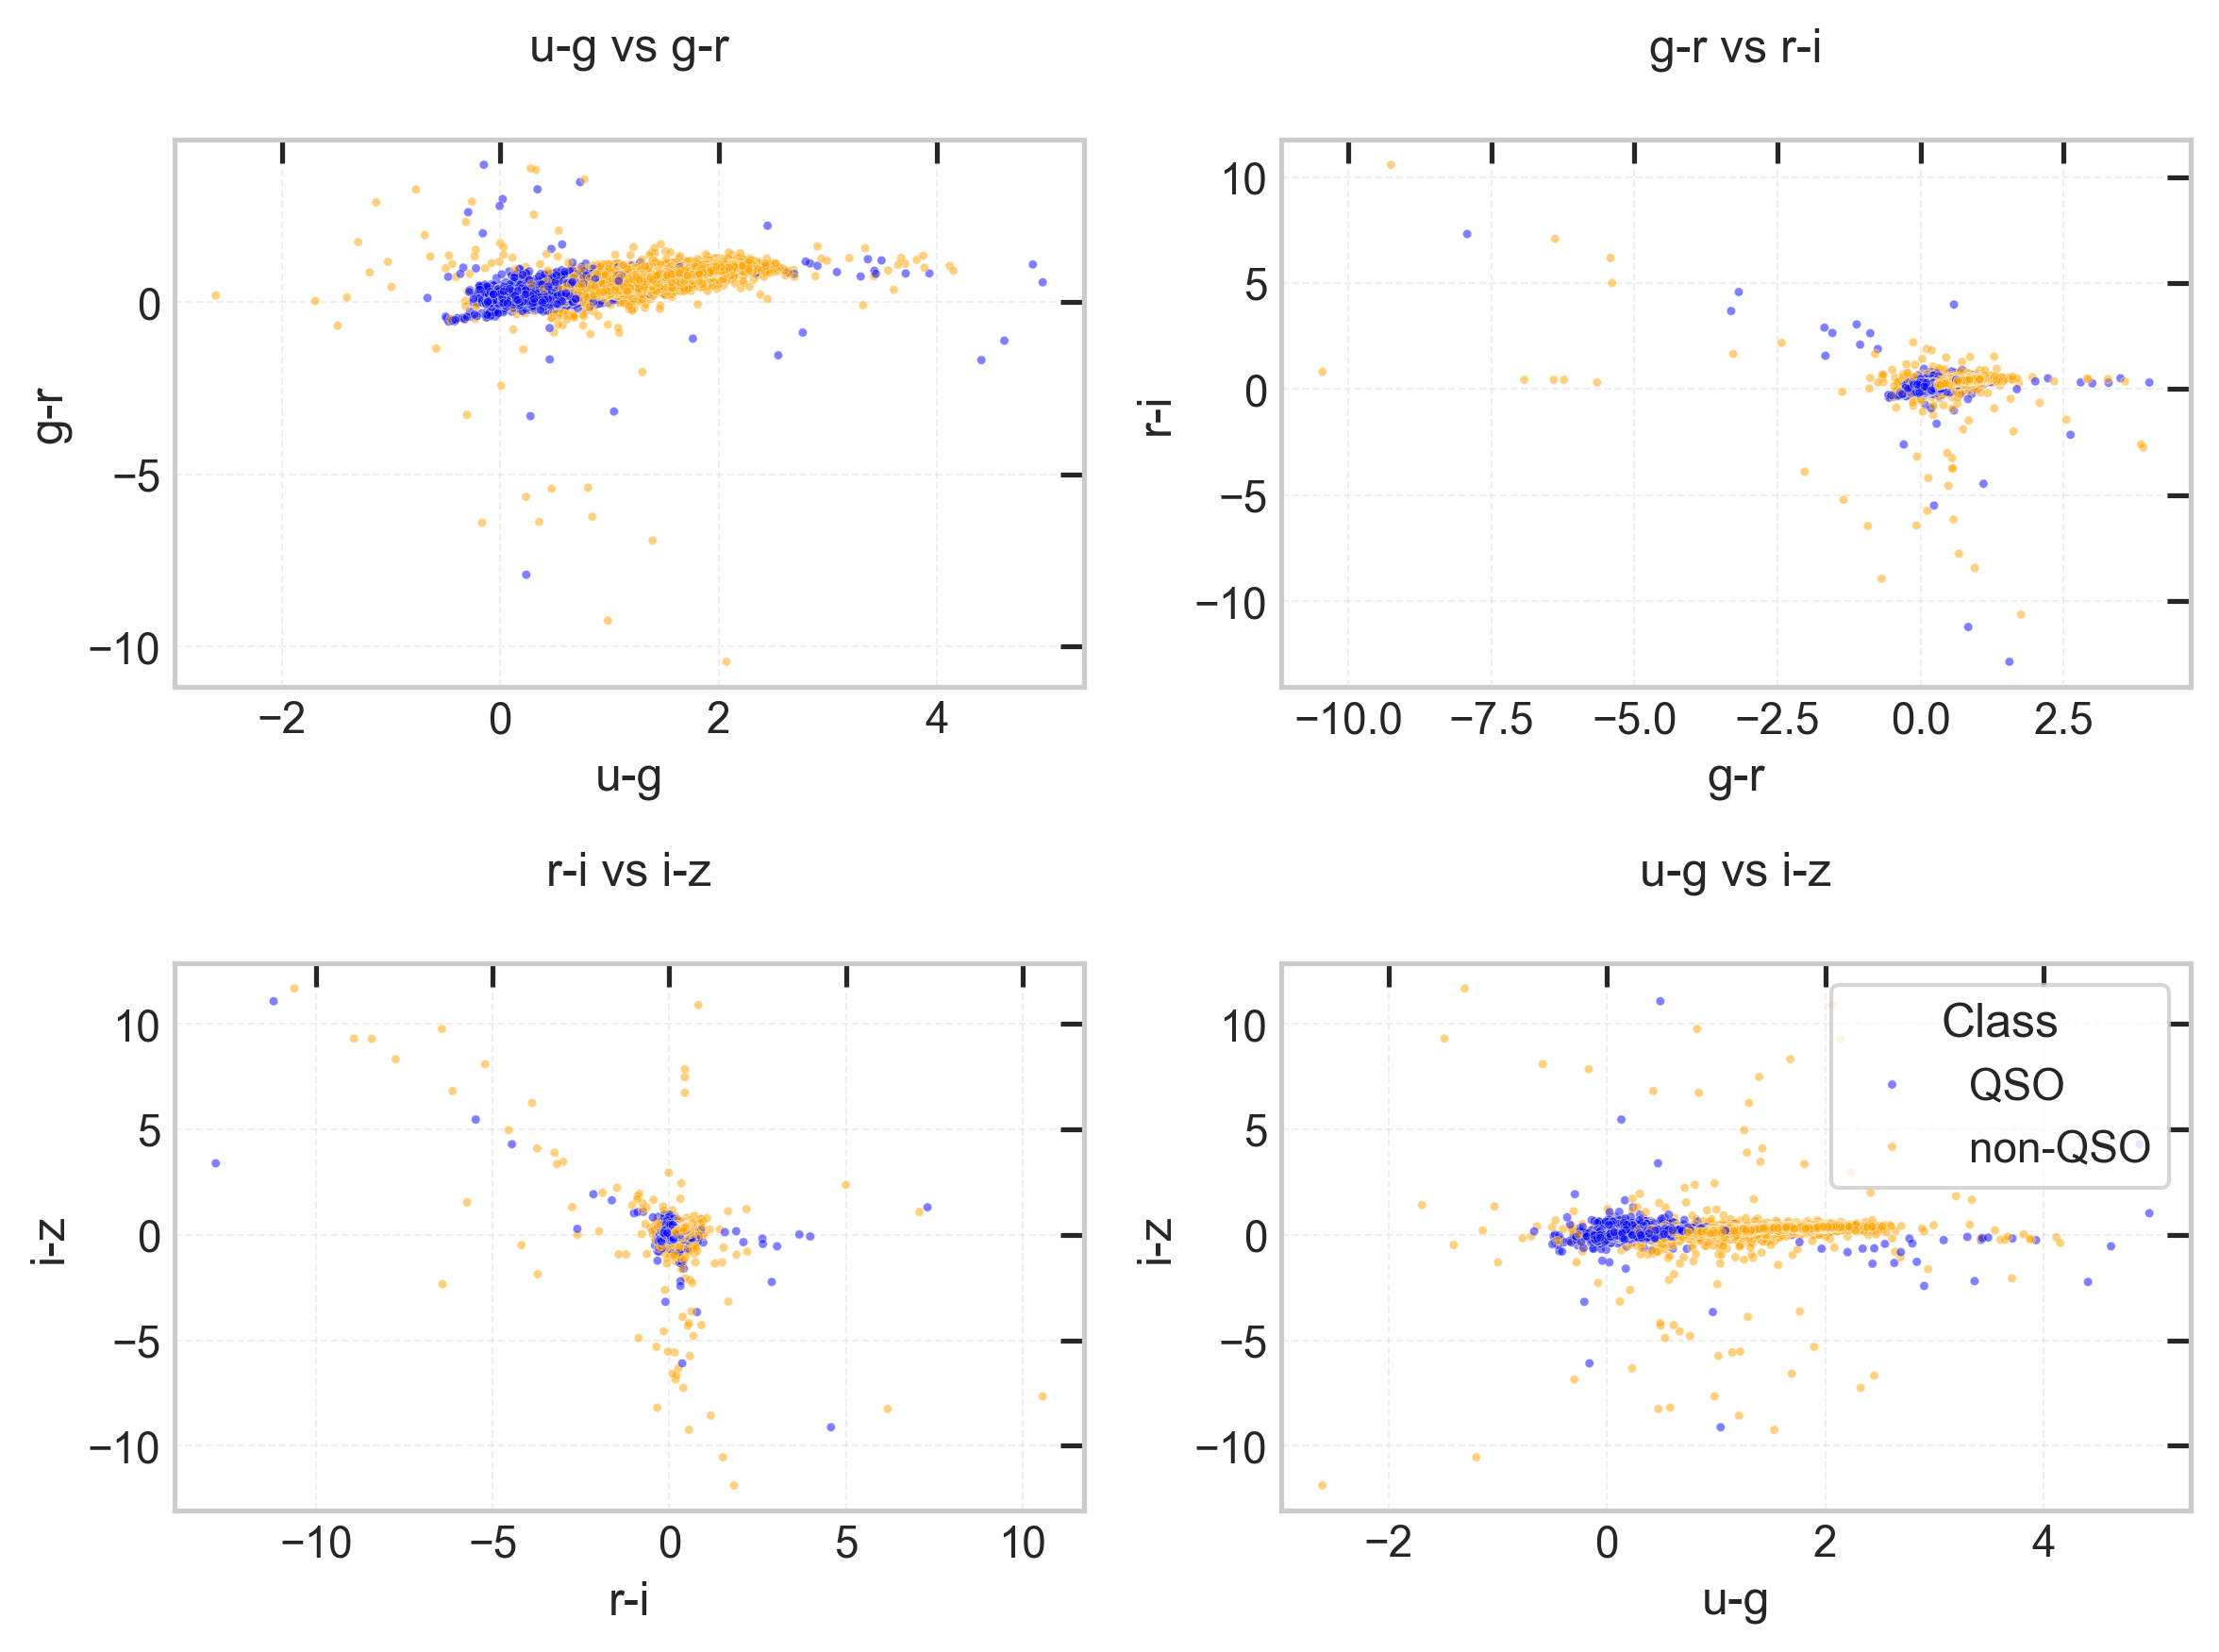

In [171]:
# Prepare dataframe for seaborn
df = pd.DataFrame(X, columns=['u-g', 'g-r', 'r-i', 'i-z'])
df['class'] = np.where(y == 1, 'QSO', 'non-QSO')

# Seaborn color palette
palette = {'non-QSO': 'orange', 'QSO': 'blue'}

# Plot setup
sns.set_theme(style="whitegrid", rc={'figure.dpi': 300, 'savefig.dpi': 300})

fig, axs = plt.subplots(2, 2, figsize=(8, 6))

# Define axes
sns.scatterplot(data=df, x='u-g', y='g-r', hue='class', palette=palette,
                s=5, alpha=0.5, ax=axs[0, 0], legend=False)
axs[0, 0].set_title('u-g vs g-r')

sns.scatterplot(data=df, x='g-r', y='r-i', hue='class', palette=palette,
                s=5, alpha=0.5, ax=axs[0, 1], legend=False)
axs[0, 1].set_title('g-r vs r-i')

sns.scatterplot(data=df, x='r-i', y='i-z', hue='class', palette=palette,
                s=5, alpha=0.5, ax=axs[1, 0], legend=False)
axs[1, 0].set_title('r-i vs i-z')

sns.scatterplot(data=df, x='u-g', y='i-z', hue='class', palette=palette,
                s=5, alpha=0.5, ax=axs[1, 1])
axs[1, 1].set_title('u-g vs i-z')

# Shared formatting
for ax in axs.flat:
    ax.tick_params(direction='in', top=True, right=True)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)

# Clean legend (from bottom-right plot only)
handles, labels = axs[1, 1].get_legend_handles_labels()
axs[1, 1].legend(handles=handles, labels=labels, loc='upper right', title='Class')

plt.tight_layout()
plt.savefig("seaborn_color_color_qso_vs_nonqso.png", bbox_inches='tight')
plt.show()


In [ ]:
import pandas as pd

df_dict = {
    'ug': (data['u'] - data['g']).to_numpy(),
    'gr': (data['g'] - data['r']).to_numpy(),
    'ri': (data['r'] - data['i']).to_numpy(),
    'iz': (data['i'] - data['z']).to_numpy()
}

df = pd.DataFrame(df_dict)

Text(0.5, 1.0, 'DataFrame columns Pearson Correlation')

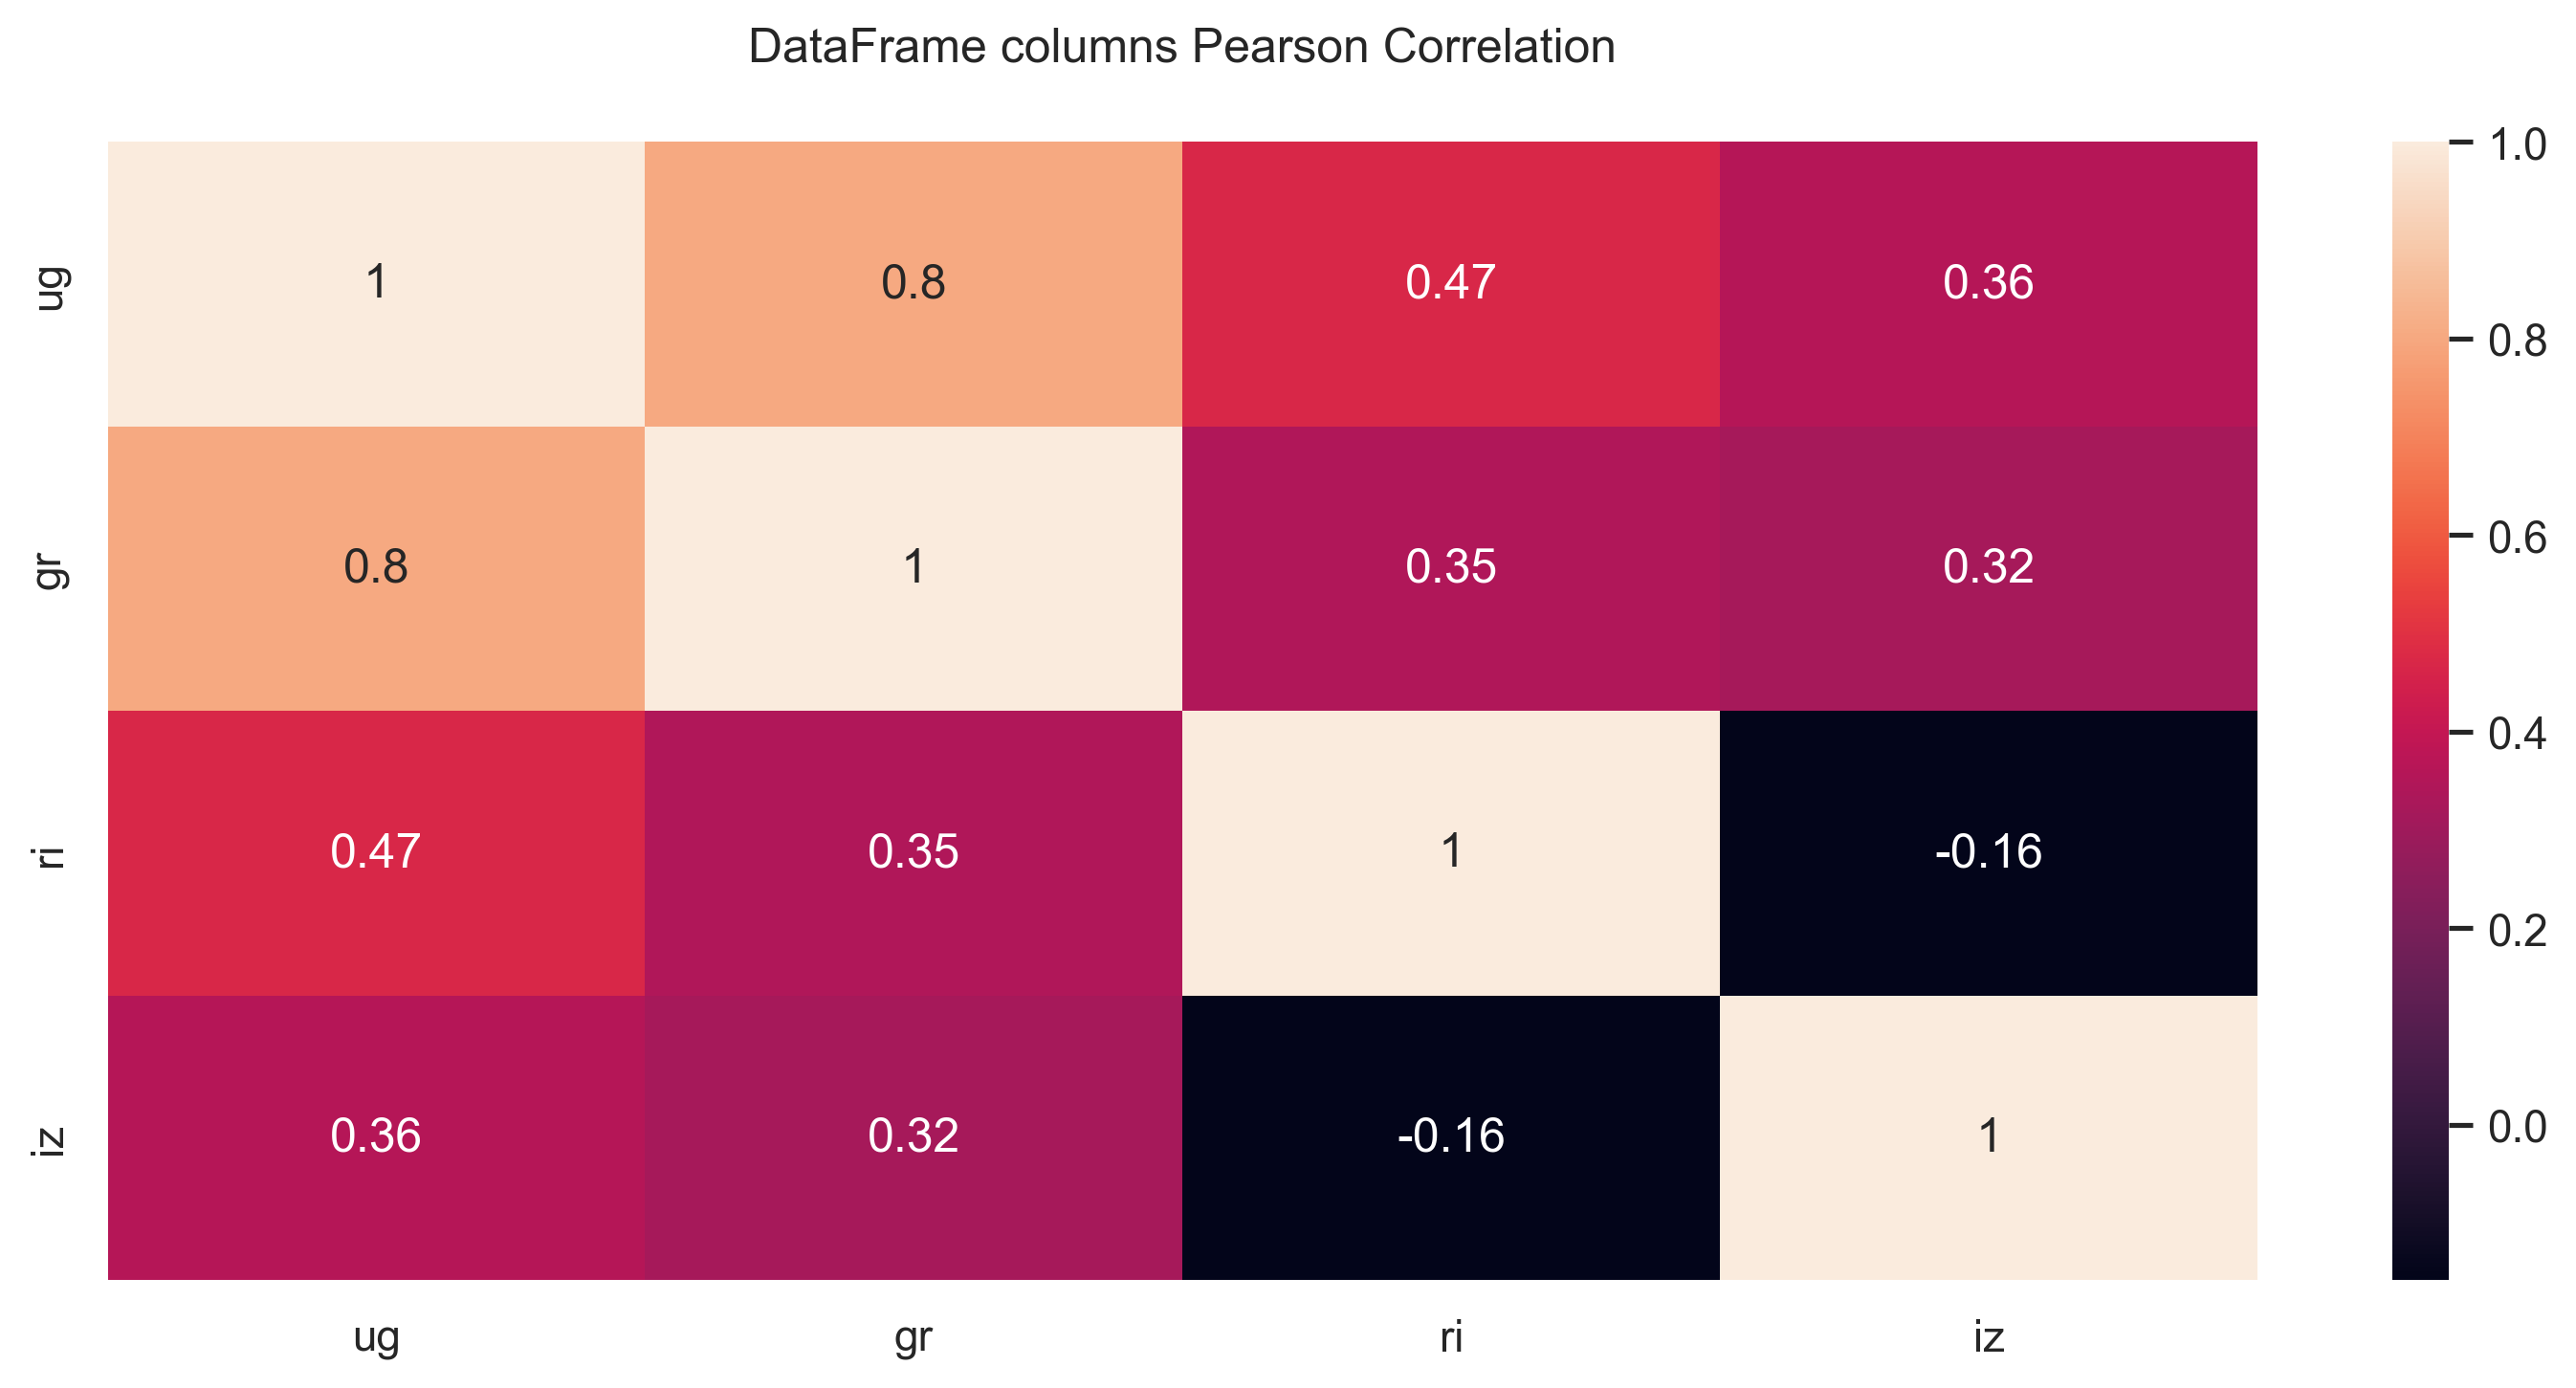

In [175]:
sns.heatmap(df.corr(method='pearson'), annot=True)
plt.title('DataFrame columns Pearson Correlation')

- gr and ug are highly correlated, so using both may not add much new information.
- ri and especially iz are more independent, so they are more likely to provide new, non-redundant information to the model.
- iz, in particular, has weak correlation with all other features → this makes it a strong candidate for adding new discriminatory power

## Linear Discriminant Analysis

In [64]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split

In [65]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [66]:
N_tot = len(y)
N_st = np.sum(y == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

In [162]:
from sklearn.base import clone
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import matplotlib as mtl

def completeness_contamination(predictions, y_true):
    completeness = []
    contamination = []
    for y_pred in predictions:
        TP = np.sum((y_pred == 1) & (y_true == 1))
        FP = np.sum((y_pred == 1) & (y_true == 0))
        FN = np.sum((y_pred == 0) & (y_true == 1))

        comp = TP / (TP + FN) if (TP + FN) > 0 else 0
        cont = FP / (TP + FP) if (TP + FP) > 0 else 0
        completeness.append(comp)
        contamination.append(cont)
    return np.array(completeness), np.array(contamination)

def compute_cc(X, X_train, X_test, y_train, y_test, clf, ROC=False):
    
    classifiers, predictions, y_prob = [], [], []
    Ncolors = np.arange(1, X.shape[1] + 1)

    for nc in Ncolors:
        clf_i = clone(clf)
        clf_i.fit(X_train[:, :nc], y_train)
        y_pred = clf_i.predict(X_test[:, :nc])
        y_prob.append(clf_i.predict_proba(X_test[:, :nc])[:, 1])

        classifiers.append(clf_i)
        predictions.append(y_pred)

    completeness, contamination = completeness_contamination(predictions, y_test)

    print("completeness", completeness)
    print("contamination", contamination)
    
    d = {
        'completeness': completeness,
        'contamination': contamination,
        'classifiers': classifiers,
        'predictions': predictions,
        'proba': y_prob
    }
    
    if ROC:
        y_score = d['classifiers'][-1].predict_proba(X_test)[:, 1]

        # ----------------------------
        # Step 4: Compute ROC and AUC
        # ----------------------------
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)

        # ----------------------------
        # Step 5: Plot ROC Curve
        # ----------------------------
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    return d 

def cross_validate_gmm_components_kfold(X, y, classifier, n_components_list, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []

    for n in n_components_list:
        accs = []
        for train_idx, test_idx in kf.split(X):
            clf = classifier(n, tol=1e-5, covariance_type='full')
            clf.fit(X[train_idx], y[train_idx])
            y_pred = clf.predict(X[test_idx])
            accs.append(accuracy_score(y[test_idx], y_pred))
        scores.append(np.mean(accs))

    best_n = n_components_list[np.argmax(scores)]
    print(f"Best n_components (via KFold): {best_n}")
    return best_n, scores

from sklearn.metrics import roc_curve, auc

def compute_GMMbayes(X_train, X_test, y_train, y_test, classifier, n_components, ROC):
    classifiers = []
    predictions = []

    Ncolors = np.arange(1, X_train.shape[1] + 1)

    for nc in Ncolors:
        clf = classifier(n_components, tol=1E-5, covariance_type='full')
        clf.fit(X_train[:, :nc], y_train)
        y_pred = clf.predict(X_test[:, :nc])

        classifiers.append(clf)
        predictions.append(y_pred)

    completeness, contamination = completeness_contamination(predictions, y_test)

    print("completeness", completeness)
    print("contamination", contamination)

    d = {
        'completeness': completeness,
        'contamination': contamination,
        'classifiers': classifiers,
        'predictions': predictions,
    }
    
    if ROC:
        y_score = d['classifiers'][-1].predict_proba(X_test)[:, 1]  # Probability of class 1
        mtl.rcdefaults()  # Resets rcParams to default values

        # ----------------------------
        # Step 4: Compute ROC and AUC
        # ----------------------------
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)

        # ----------------------------
        # Step 5: Plot ROC Curve
        # ----------------------------
        fig = plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return d


In [167]:
def classify(classifier, X, X_train, X_test, y_train, y_test, cc_func, GM=False, n_components=0, ROC=False):
    
    try:
        dic = cc_func(X, X_train, X_test, y_train, y_test,classifier, ROC)
    except:
        dic = cc_func(X_train, X_test, y_train, y_test,classifier, n_components, ROC)
        
    clf = dic['classifiers'][1]
    
    Ncolors = np.arange(1, X.shape[1] + 1)

    padding_x = 0.05 * (X[:, 0].max() - X[:, 0].min())
    padding_y = 0.05 * (X[:, 1].max() - X[:, 1].min())

    xlim = (X[:, 0].min() - padding_x, X[:, 0].max() + padding_x)
    ylim = (X[:, 1].min() - padding_y, X[:, 1].max() + padding_y)

    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 200),
                        np.linspace(ylim[0], ylim[1], 200))
    
    grid = np.c_[yy.ravel(), xx.ravel()]  # Note the order to match X[:, :2]
    
    Z = clf.predict_proba(grid)
    Z = Z[:, 1].reshape(xx.shape)
    
    fig = plt.figure(figsize=(10, 5))
    fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                        left=0.1, right=0.95, wspace=0.2)

    # Left plot: data and decision boundary
    ax = fig.add_subplot(121)
    im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                    s=4, lw=0, cmap=plt.cm.Oranges, zorder=2)
    im.set_clim(-0.5, 1)

    im = ax.imshow(Z, origin='lower', aspect='auto',
                cmap=plt.cm.binary, zorder=1,
                extent=xlim + ylim)
    im.set_clim(0, 1.5)
    ax.contour(xx, yy, Z, [0.5], colors='k')
    cbar = plt.colorbar(im, ax=ax, label='P(QSO)')

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.set_xlabel('$u-g$')
    ax.set_ylabel('$g-r$')    

    # Top-right: Completeness vs Ncolors
    ax = plt.subplot(222)
    ax.plot(Ncolors, dic['completeness'], 'o-k', ms=6)
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.set_ylabel('completeness')
    ax.set_xlim(0.5, 4.5)
    ax.set_ylim(-0.1, 1.1)
    ax.grid(True)

    # Bottom-right: Contamination vs Ncolors
    ax = plt.subplot(224)
    ax.plot(Ncolors, dic['contamination'], 'o-k', ms=6)
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
    ax.set_xlabel('N colors')
    ax.set_ylabel('contamination')
    ax.set_xlim(0.5, 4.5)
    ax.set_ylim(-0.1, 1.1)
    ax.grid(True)

    plt.show()


completeness [0.91587213 0.91531127 0.91587213 0.91699383]
contamination [0.06685714 0.06152961 0.06149425 0.05980449]


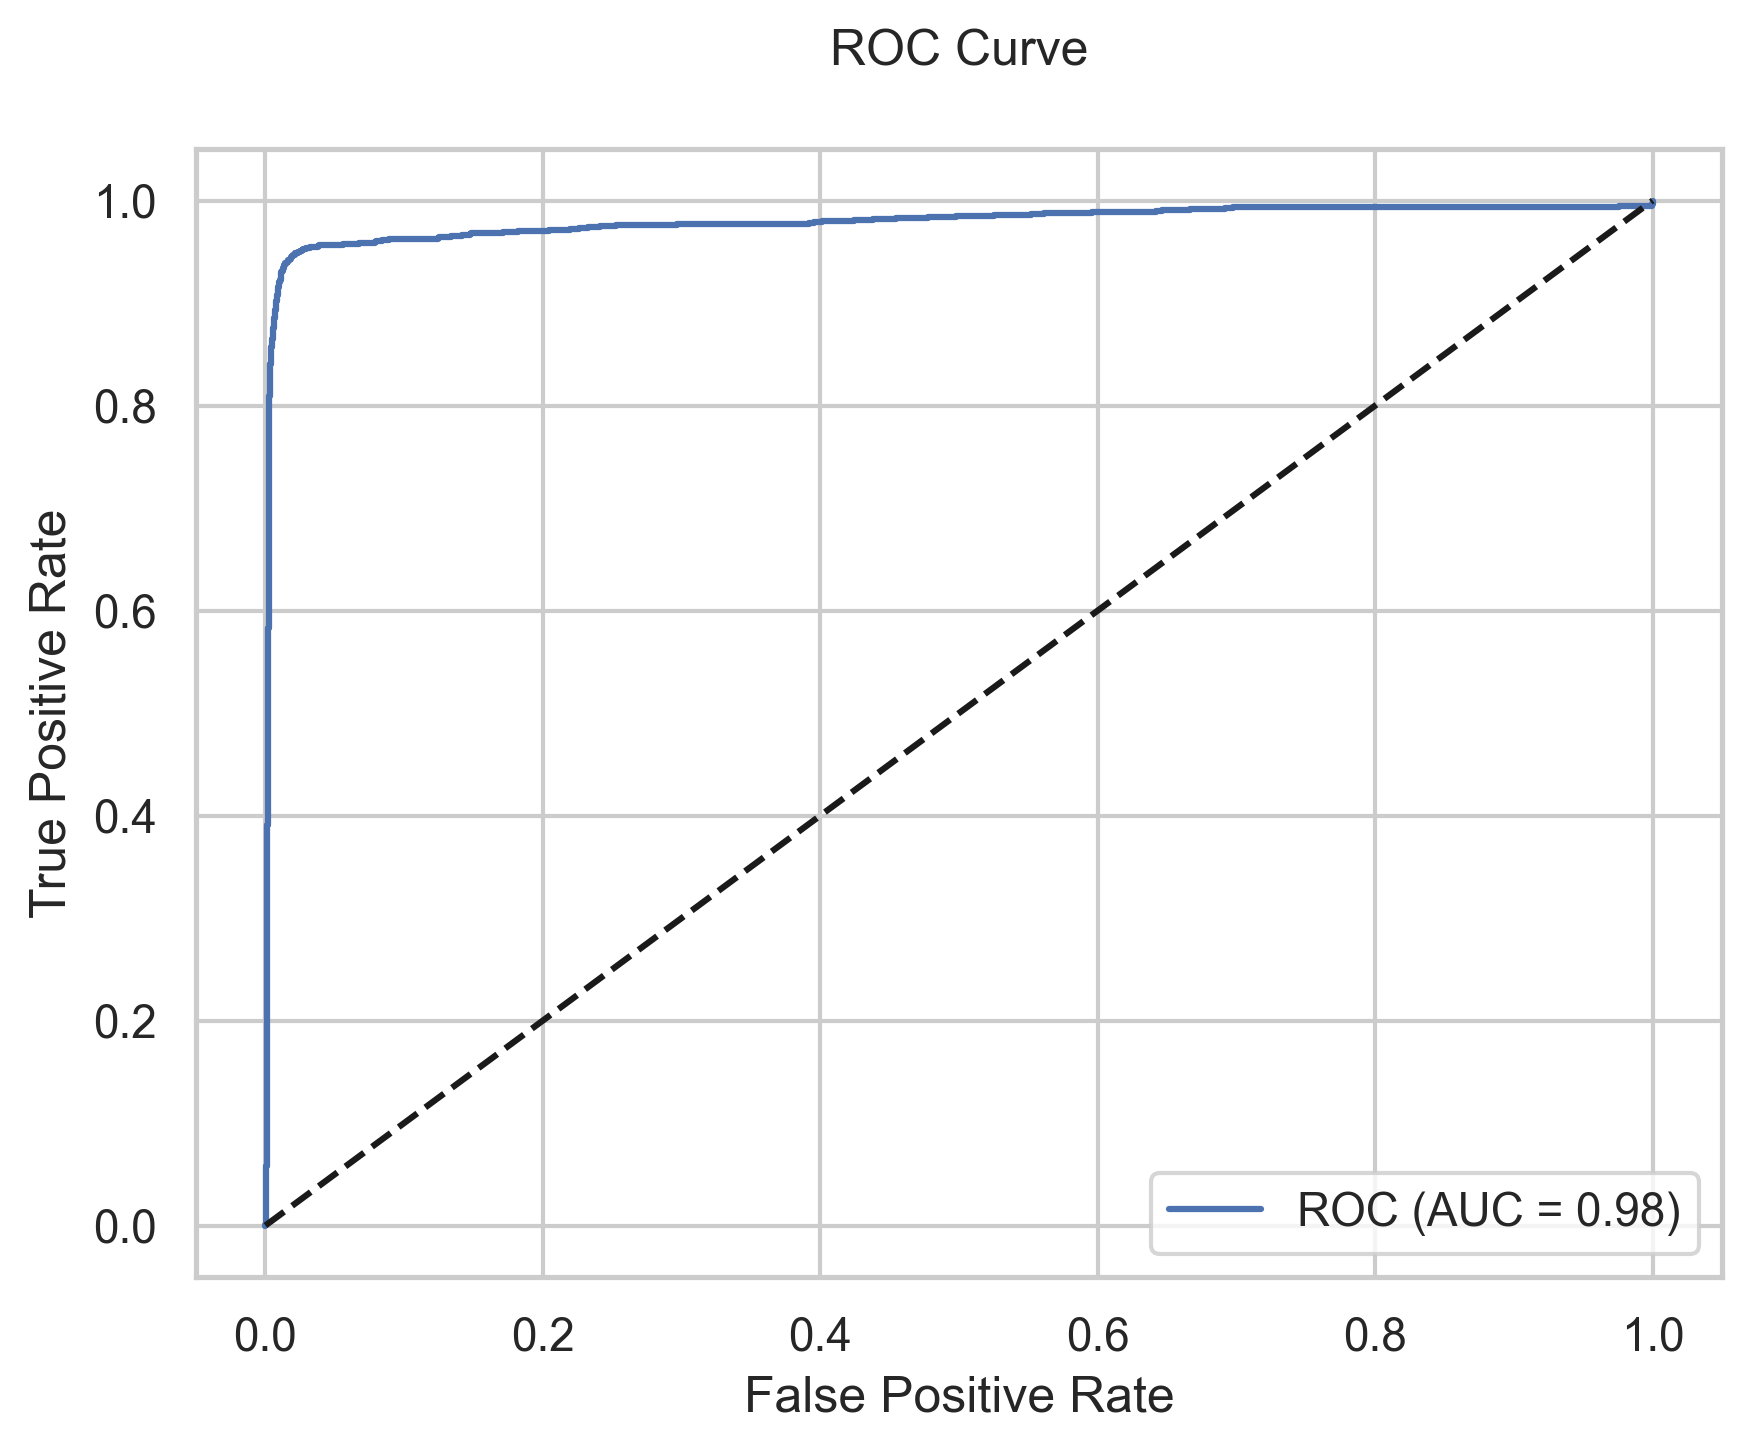

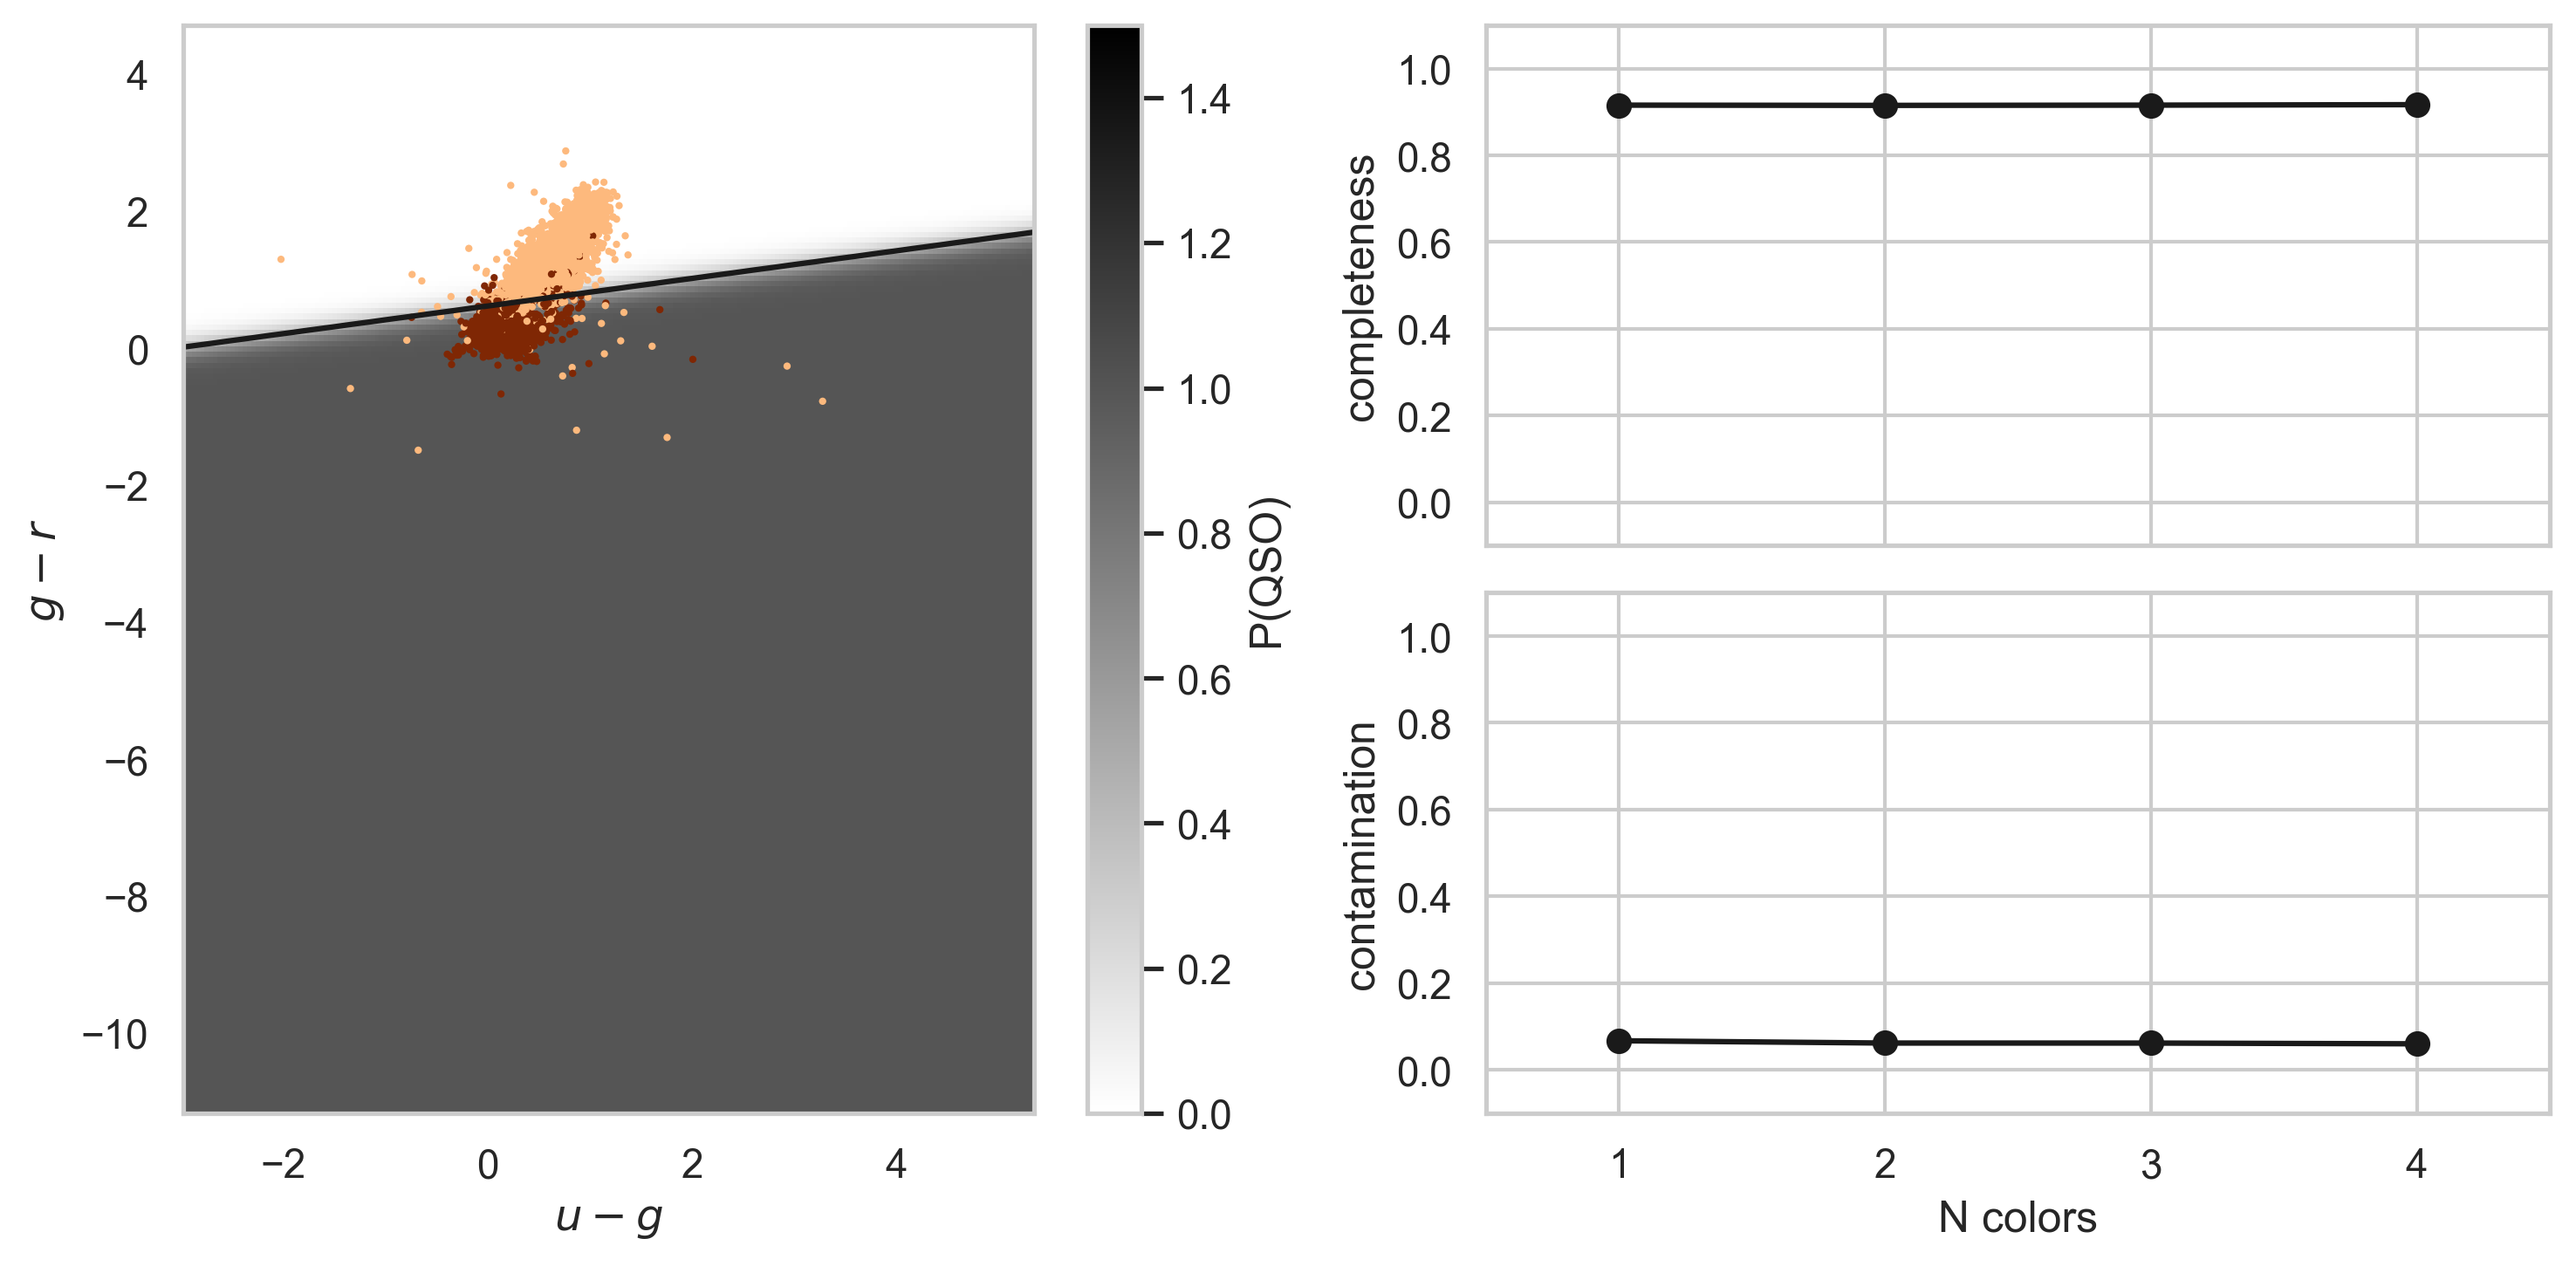

In [176]:
classify(LDA(), X, X_train, X_test, y_train, y_test, compute_cc, False, 0, True)

## Quadratic Discriminant Analysis

In [113]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

completeness [0.91531127 0.92035895 0.91979809 0.91811554]
contamination [0.06475645 0.06920023 0.06605923 0.06829824]


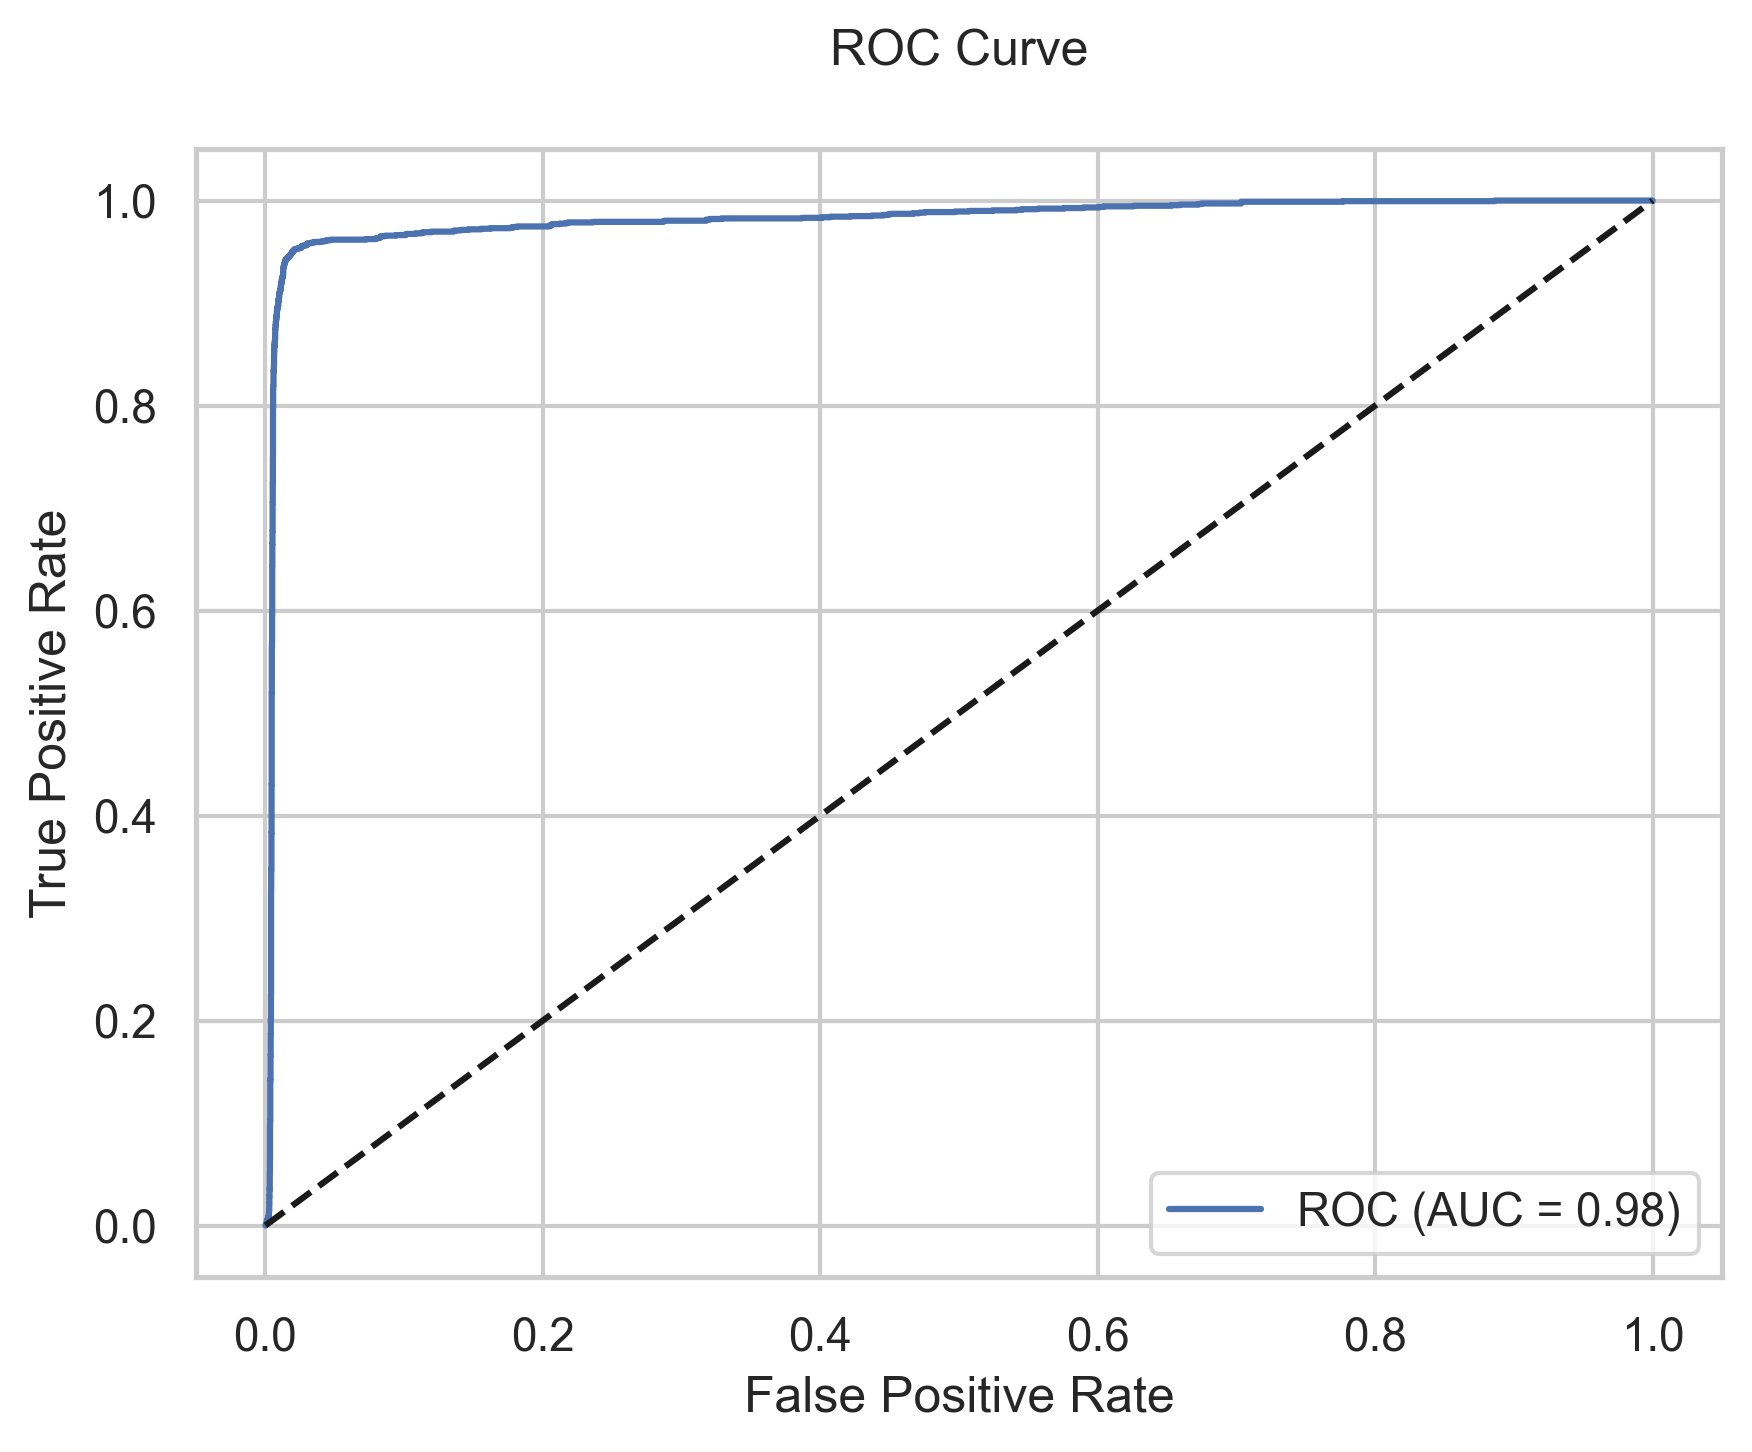

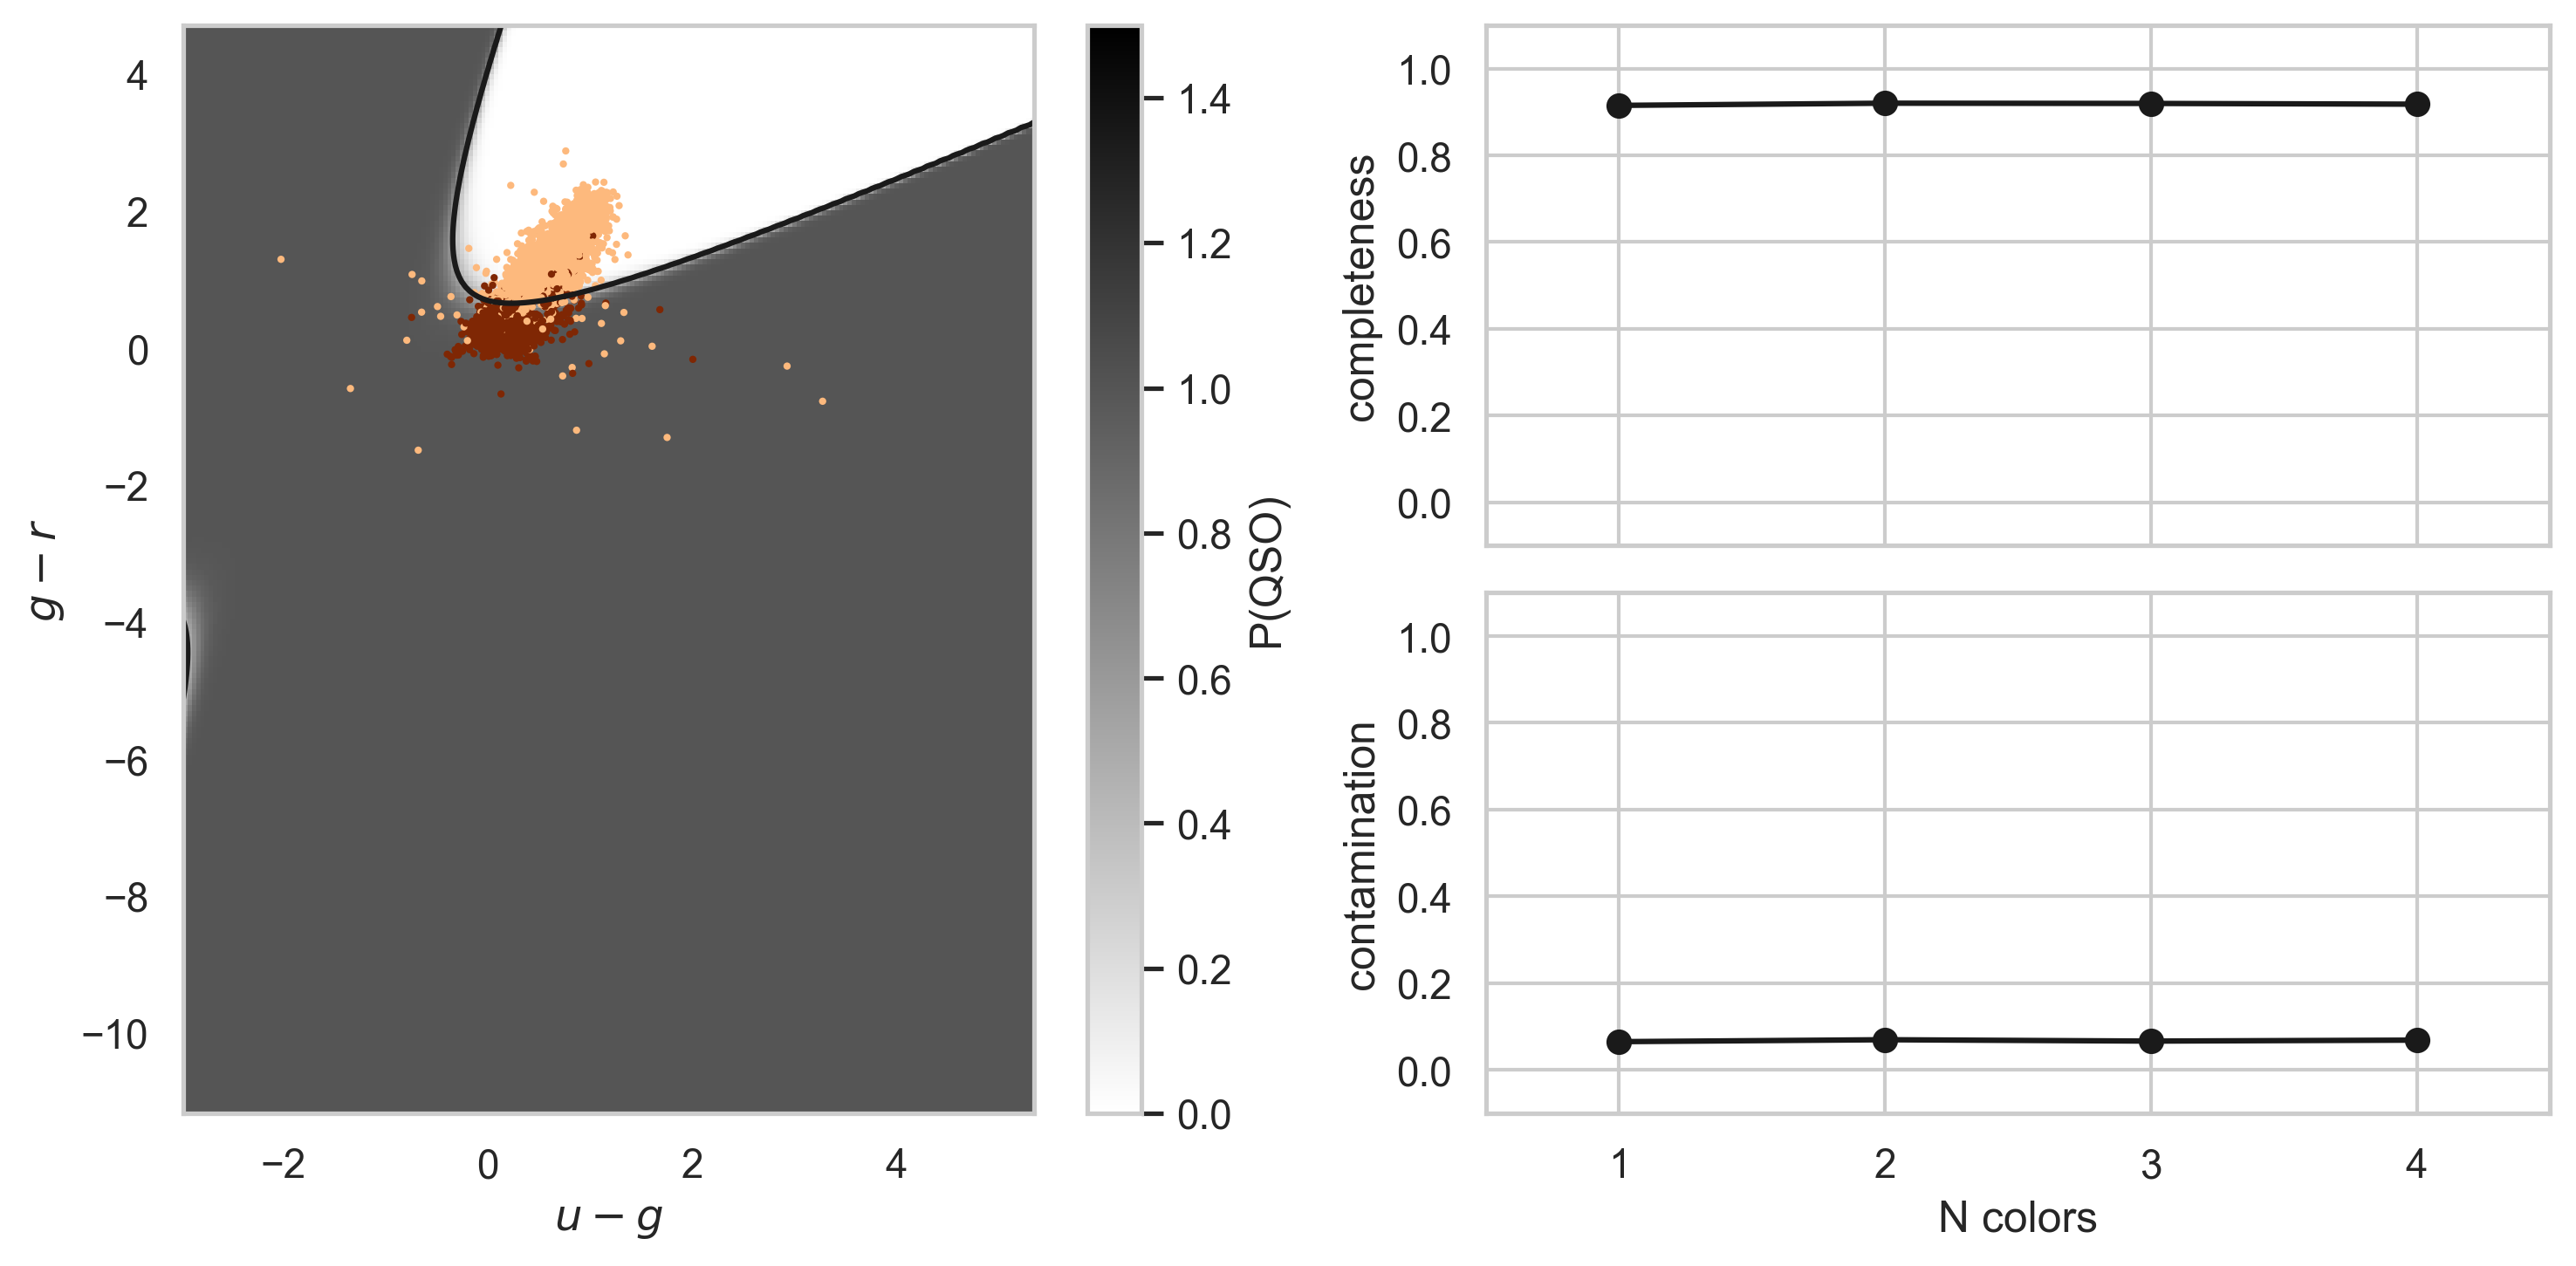

In [156]:
classify(QDA(), X, X_train, X_test, y_train, y_test, compute_cc, False, 0, True)

## GMM-Bayes Classification

In [107]:
from astroML.classification import GMMBayes

In [120]:
a, b = cross_validate_gmm_components_kfold(X, y, GMMBayes, np.linspace(1,10,2,dtype=int), 5)

c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWar

Best n_components (via KFold): 10


c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWar

completeness [0.90297252 0.91587213 0.92989344 0.9220415 ]
contamination [0.05957944 0.0577034  0.04767375 0.04418605]


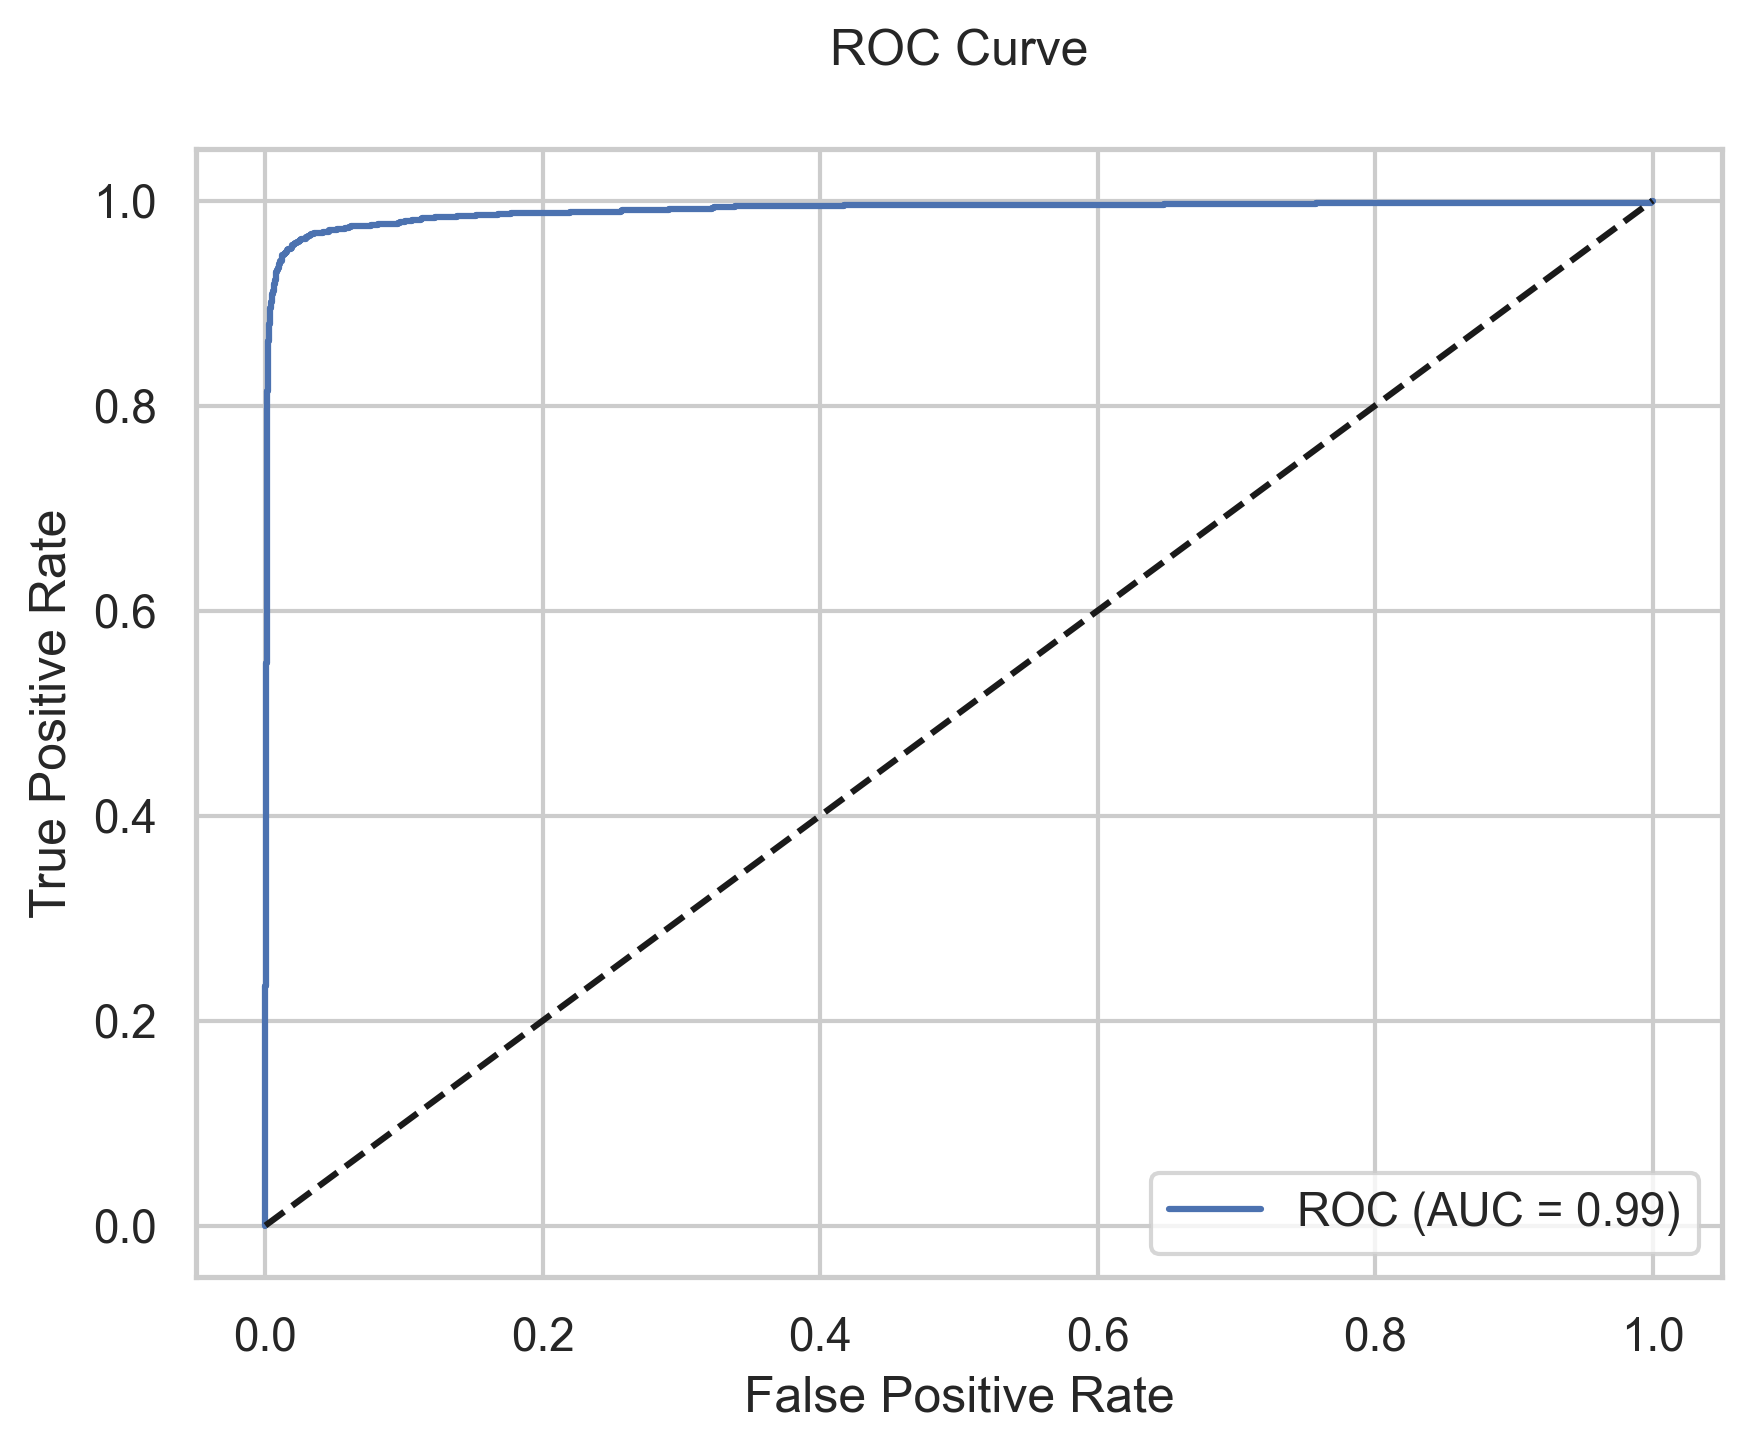

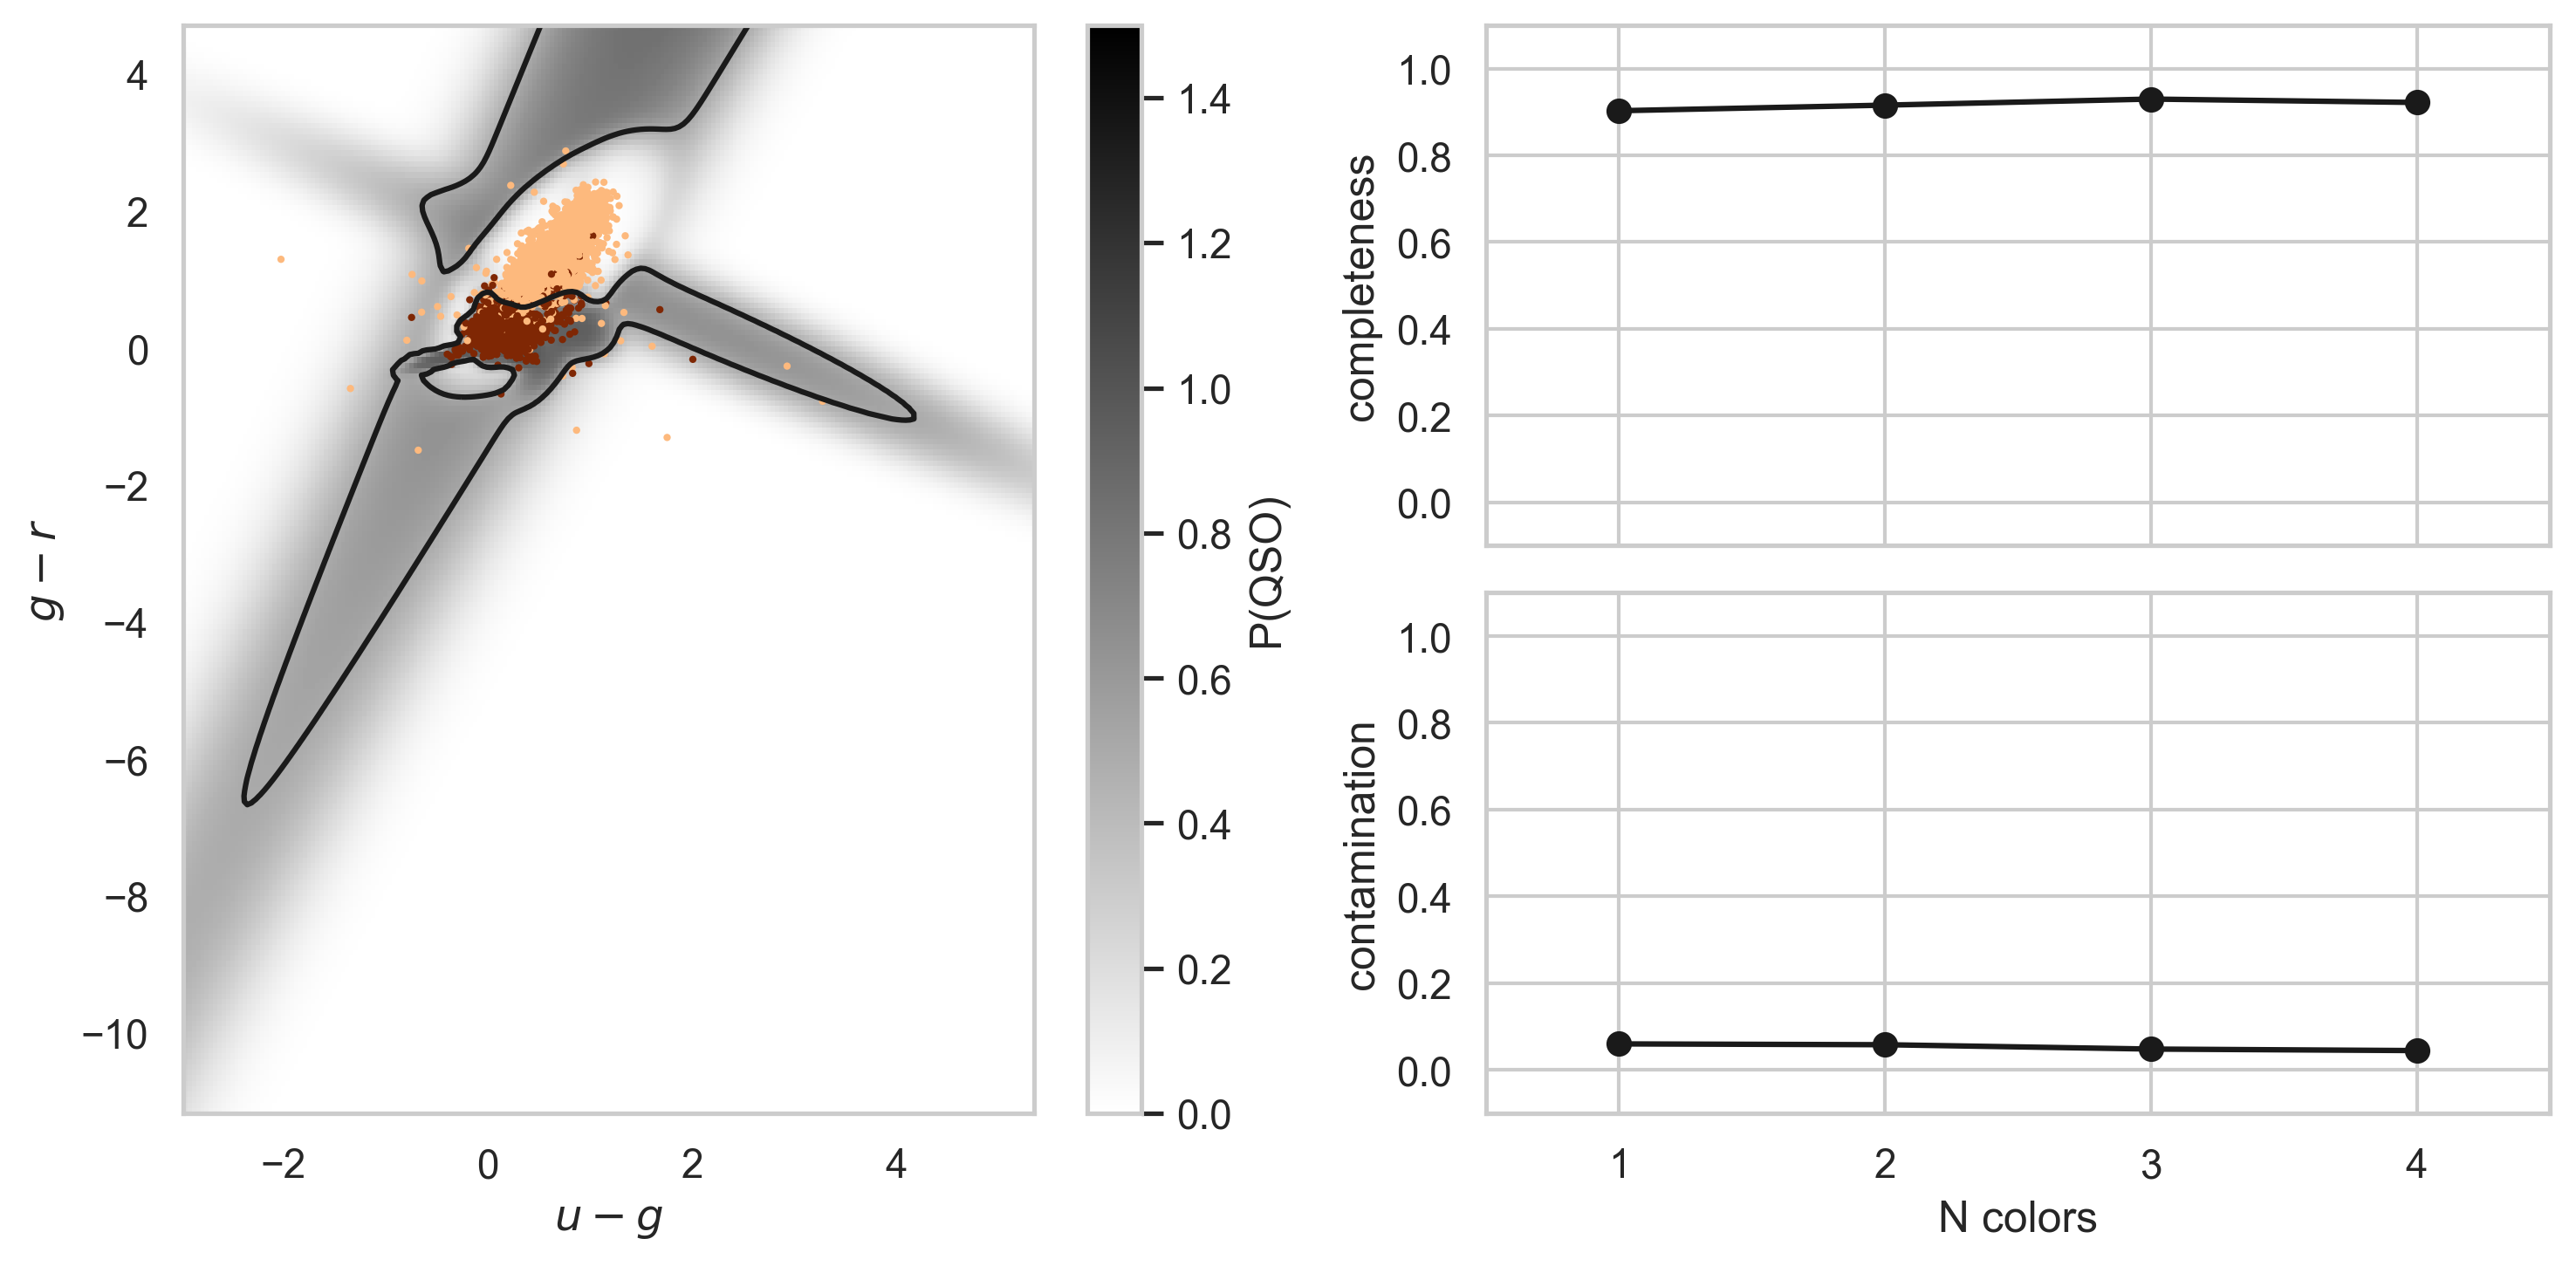

In [157]:
classify(GMMBayes, X, X_train, X_test, y_train, y_test, compute_GMMbayes, True, 10, True)

## K-Nearest Neighbours Classification

In [158]:
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

In [159]:
scores = []
kvals = np.linspace(1,20,20, dtype=int)
for k in kvals:
    clf = KNC(n_neighbors=k)
    CVpredk = cross_val_predict(clf, X, true_labels)
    scores.append(accuracy_score(true_labels, CVpredk))

max score is for k=9


Text(0, 0.5, 'Classification accuracy')

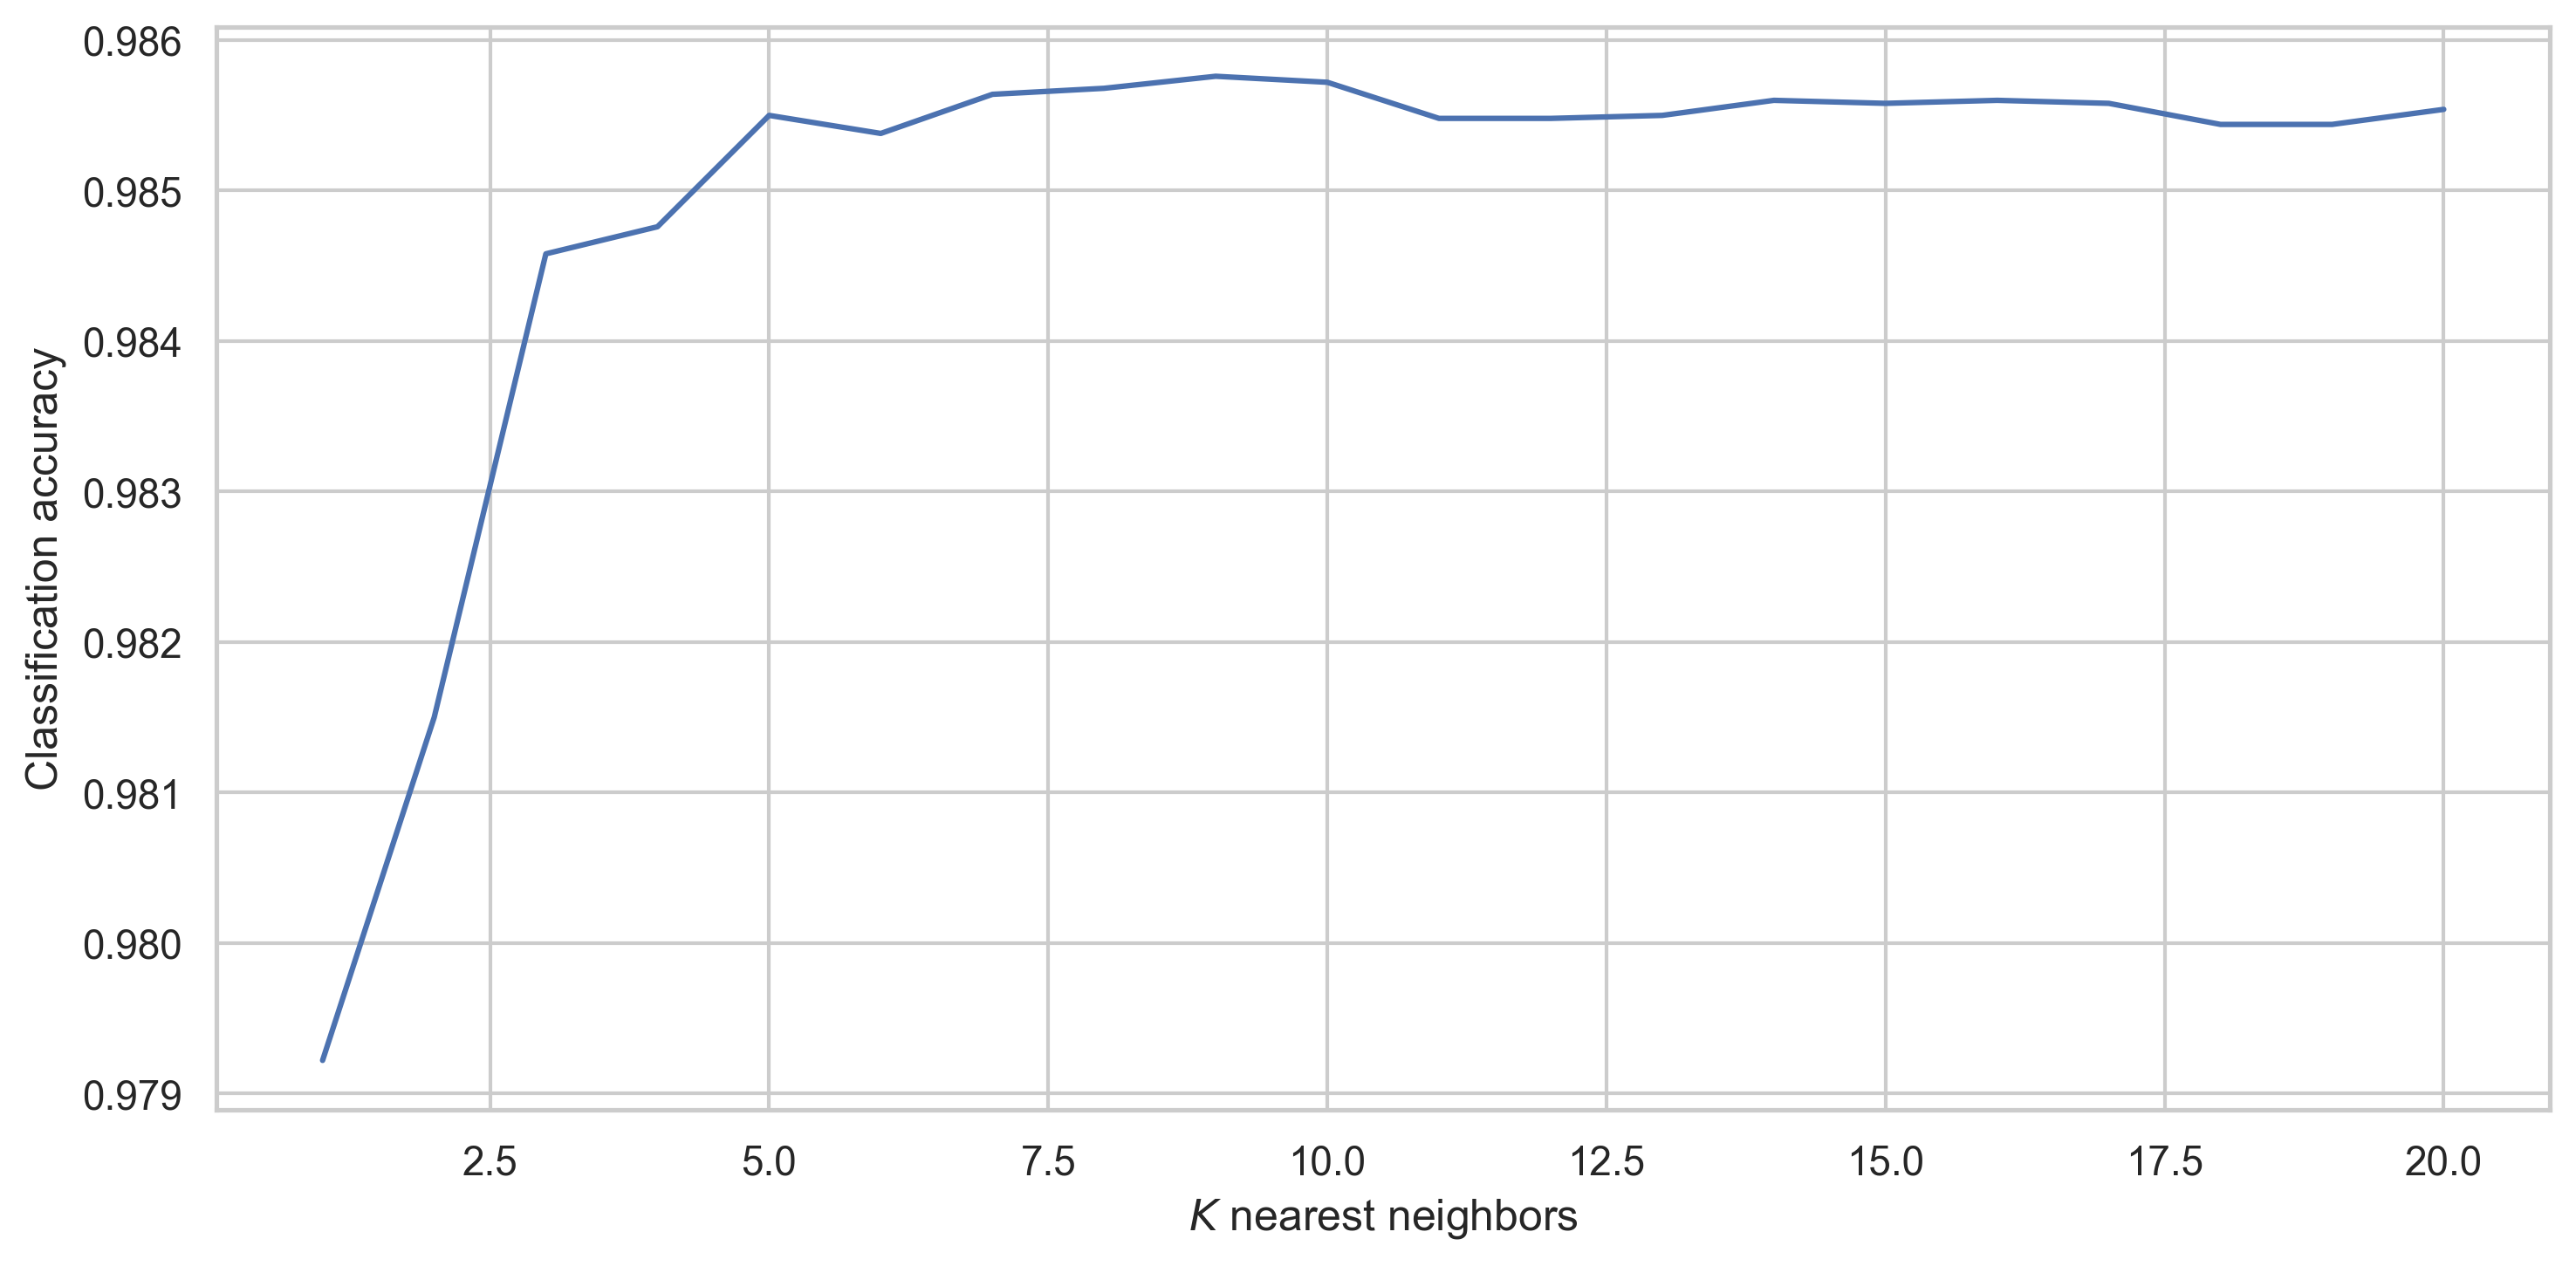

In [160]:
print("max score is for k={:d}".format(kvals[np.argmax(scores)]))
# Plot number of neighbors vs score
u = np.arange(len(scores))+1
plt.plot(u,scores)
plt.xlabel('$K$ nearest neighbors')
plt.ylabel('Classification accuracy')

completeness [0.90409422 0.90689849 0.9220415  0.931576  ]
contamination [0.05841121 0.05878929 0.04418605 0.03988439]


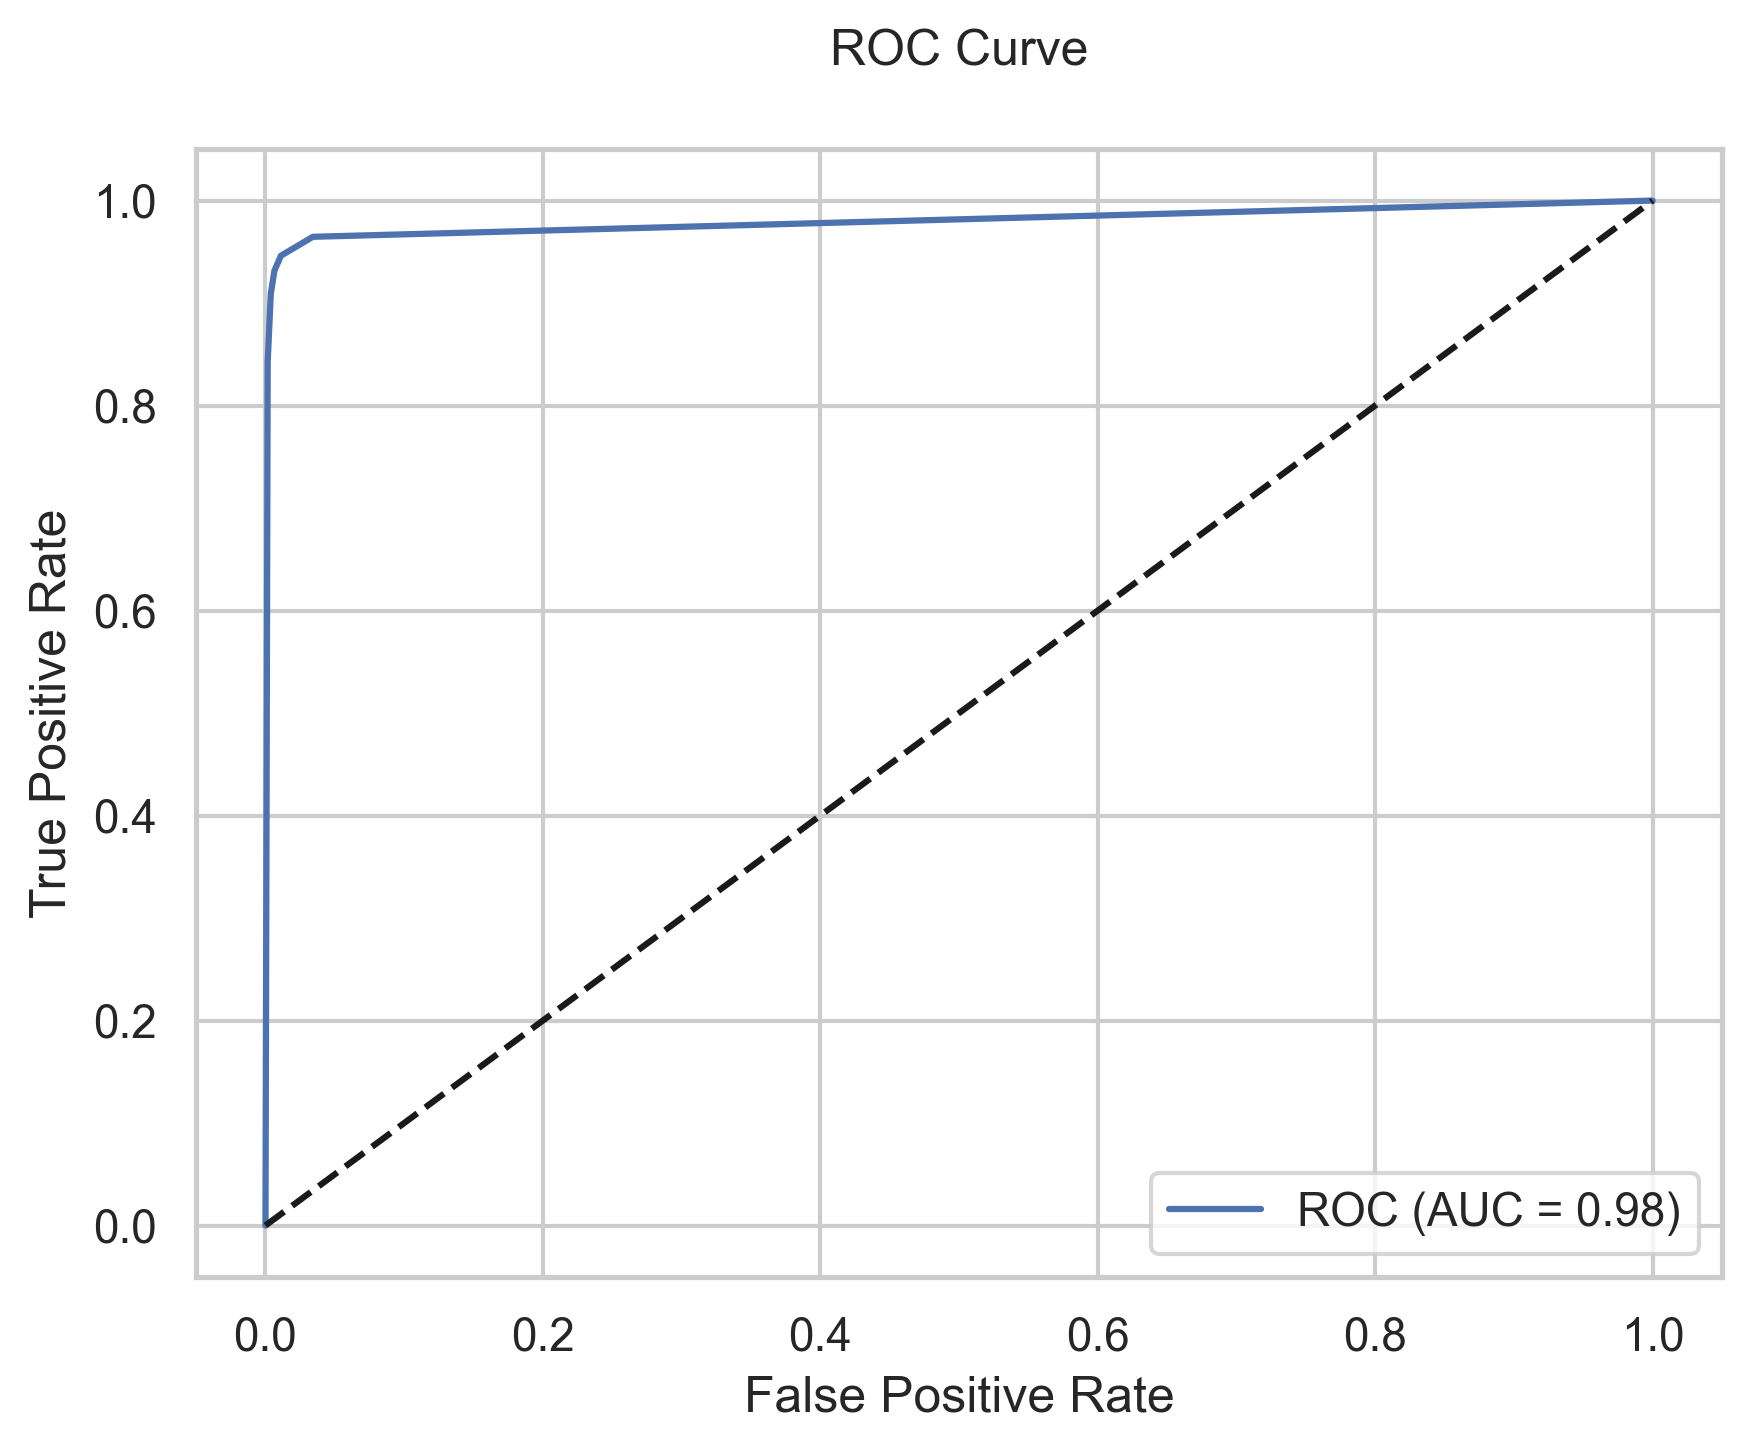

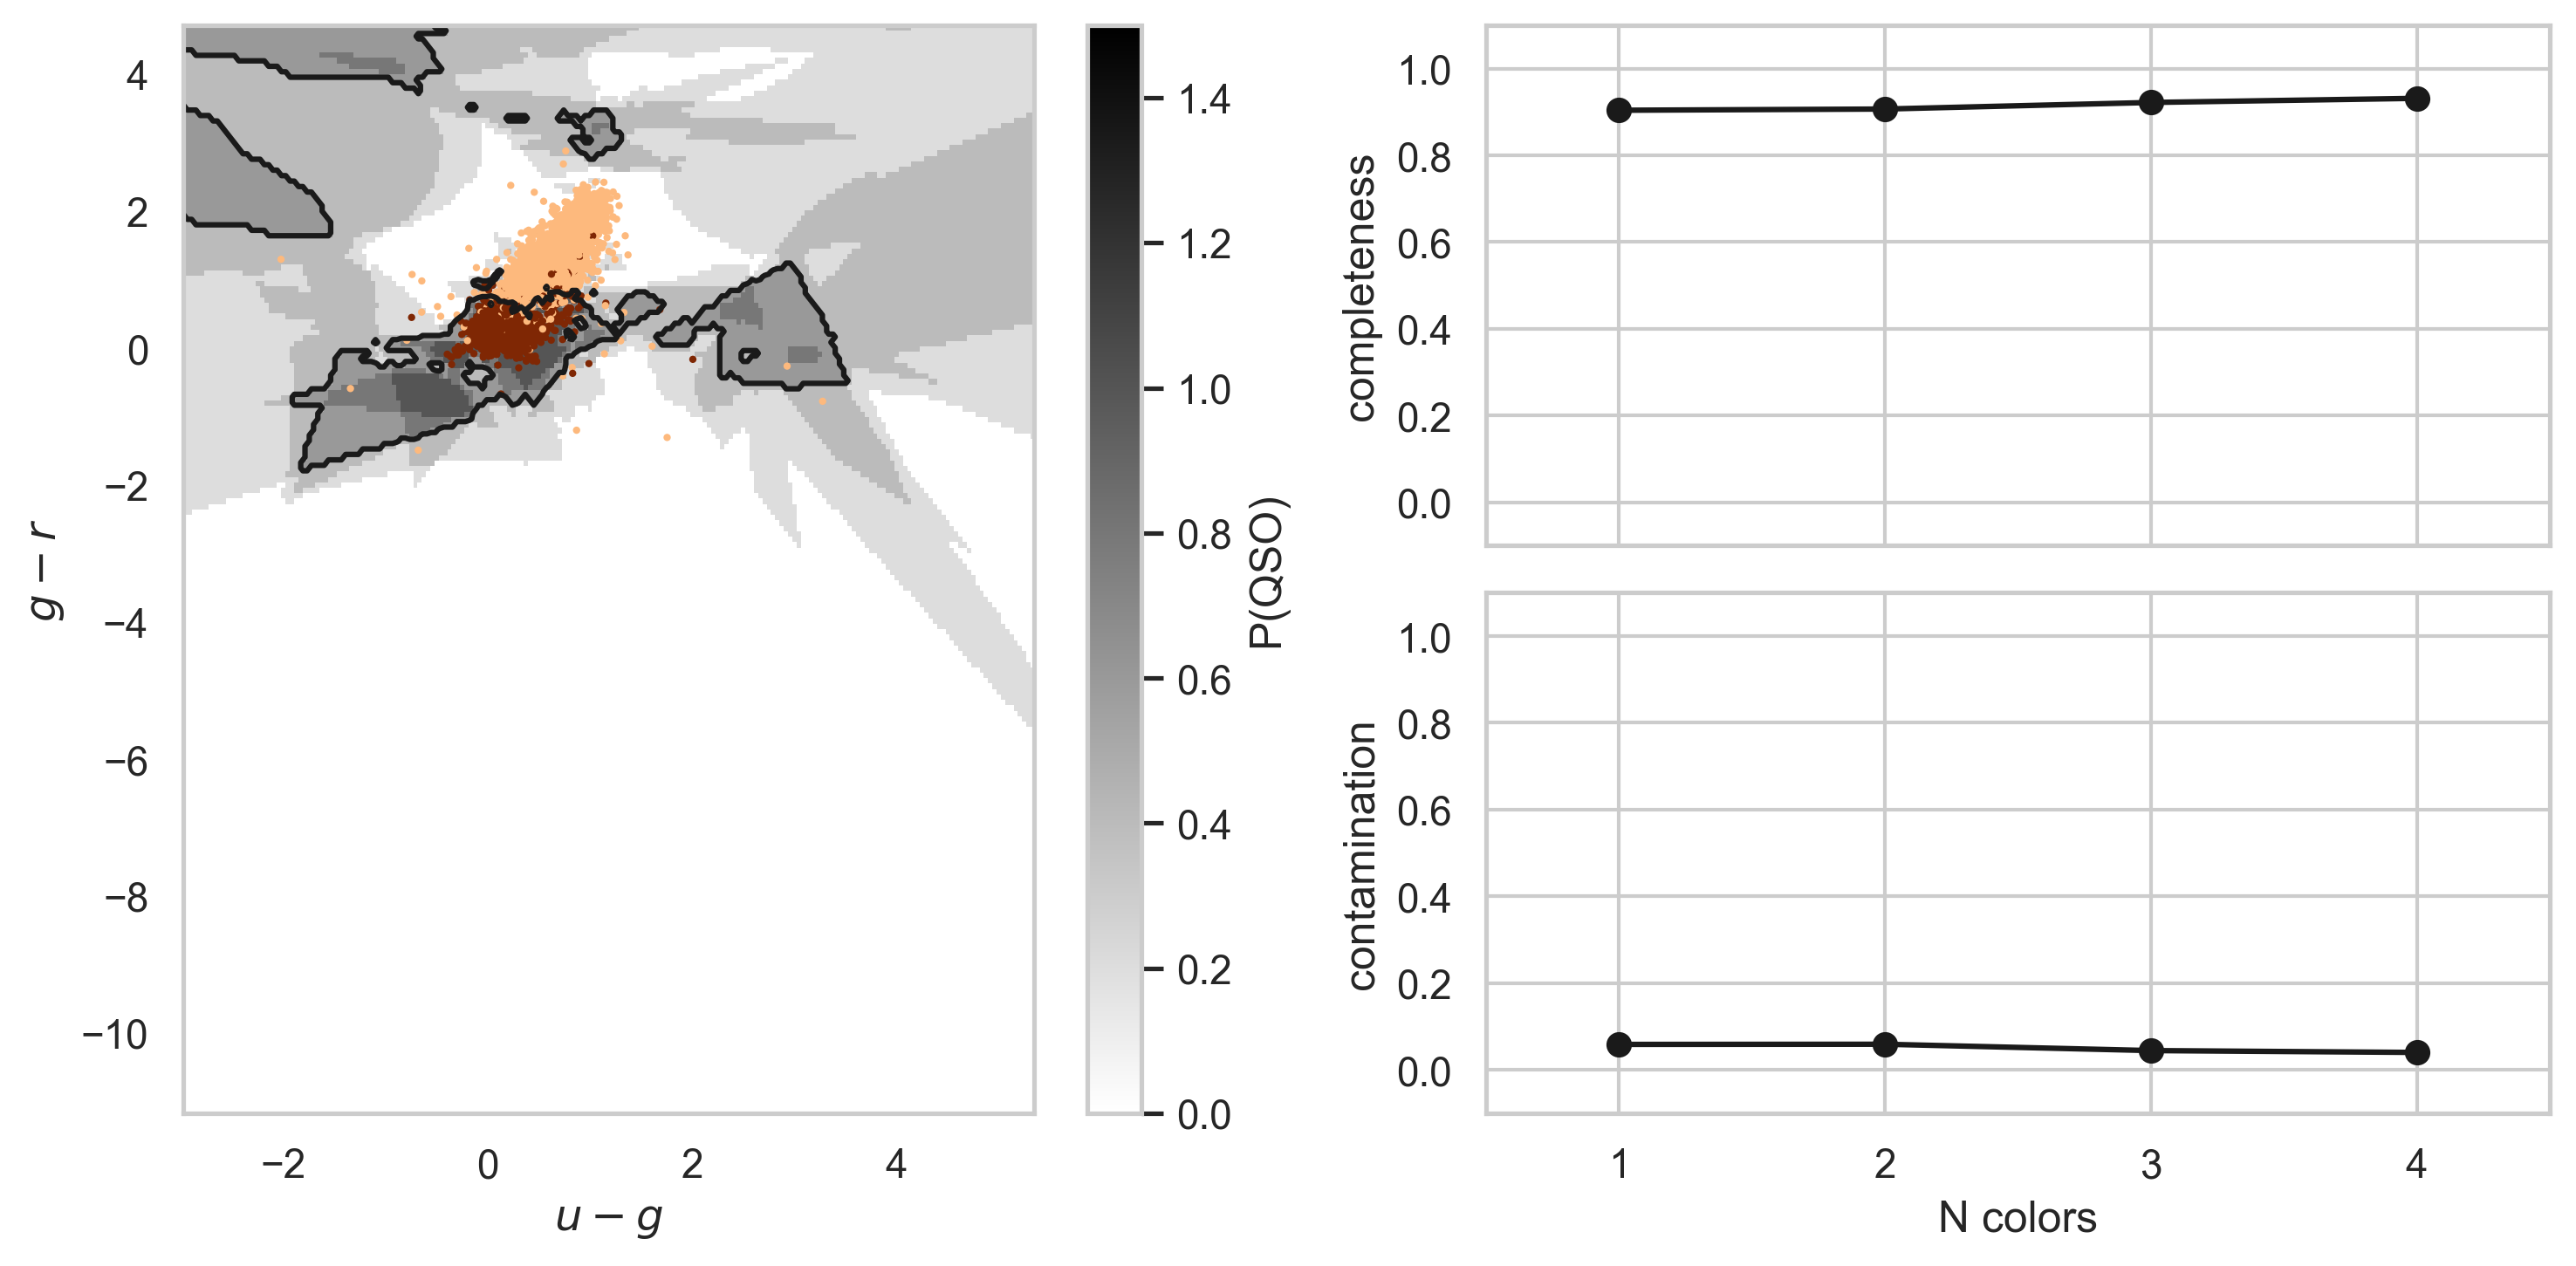

In [161]:
classify(KNC(), X, X_train, X_test, y_train, y_test, compute_cc, False, 0, True)